# Variational Autoencoder Overview

## Dimensionality Reduction
Dimensionality reduction is the process of reducing the number of features that describe some data. One can reduce the number of features by selection or extraction (a reduced number of features are created based on the old features).

An autoencoder consists of 2 sections, where the encoder is the process that produces the "new features", while the decoder reverses this process. The data compression form the encoder is called the encoded or "latent" space. Depending on the initial data distribution, the latent space dimension, and the encoder definition, the compression could lose some information that can't be recovered when decoding.

The goal is to find the best encoder/decoder pair (among all possible pairs of encoders and decoders) to keep the maximum information when encoding and has the minumum reconstruction error when decoding. This is represented by the encoder/decoder pair that results in the lowest reconstruction loss (the difference between the input data and the encoded->decoded ouput of the model).

## PCA
PCA involves linear combinations of the old features. These new features are projections of the old data onto a new space (for each combination). To pick the most meaningful new features, we calcuate the distance between the new projections (euclidean distance) and the new features with the lowest distance are the best encodings with the fewest information loss!

Ex: Imagine a 3D scatter plot where the points are actually linear in that space. A straight line (the new projection) could fit that really well!

## Why Variation?
A deep encoder/decoder can accomplish high dimensionality reduction while keeping reconstruction loss low. This means that an input with a lot of features (dimensions) can eventually be projected to a single dimension. Because the degrees of freedom in the model is high (more complex functions exist in the model that can transform the input into a really specific output), an encoder with "infinite power" can take "N" data points during training, and encode them as "1,2,3,...N" (like it's along a number line in the latent space), and the decoder can transform that with no loss.

This could be an issue, because there is a lack of regularity (overfitting way too much on unecessary patterns like noise in data). This means that in the latent space, there isn't a clear or interpretable structure/pattern.

### Aside: Degrees of Freedom
For a linear regression model that fits 1 variable, we have 1 slope and 1 bias, so 1 degree of freedom. For a linear regression with 3 inputs, we have 3 slopes so that's 3 degrees of freedom. The complexity of a model fit from data is commonly based on the number of parameters that were fit. A more precise definition states that a model's degrees of freedom is more related to the number of non-zero parameters instead of the total parameter count.

## Variational Autoencoder Definition
So, a variational autoencoder is an autoencoder whose training is regularised to avoid overfitting and ensure that the latent space has good properties that enable generative process.

The neural network architecture is the same. However, to introduce some regularisation of the latent space, there is a slight modification to the encoding-decoding process, where instead of encoding an input as a single point (for each new feature dimension in the latent space), we encode it as a distribution over the latent space.

Steps:
1. Input is encoded as a *distribution* over the latent space
2. A point from the latent space is sampled from that distribution
3. The sampled point is decoded and the reconstruction error can be computed
4. Reconstruction error is backpropagated through the network.

The distribution of the encoded input over the latent space is usually *normal* so that the encoder can be trained to return the mean and the covariance matrix that describe these Gaussians.

This distribution with some variance, instead of a single point, makes it possible to express the latent space regularisation. There is local regularisation due to variance control and global regularisation of the latent space because of the mean control.

The model is forced to regularise both the covariance matrix and the mean of the distributions returned by the encoder. The distributions, consequently, have to be close to a standard normal distribution (centered and reduced). The means that the covar matrix should be close to identity and the mean should be close to 0.

Questions:
1. For the mean and covar matrix, maybe for a single point that has "k" features in the latent space, with "n" points in the distribution, the points togther make a "n x k" matrix? Does that mean the mean is across k, so mean is "1xk" matrix? Does that mean covar matrix is "k x k", such that each point has an overall covariance among each kth feature, and we're seeing how different features are correlated with each other?
2. If the encoder outputs a mean and covar now, how big should the distribution be?
3. I guess the encoder will have to learn a reasonable mean and covar distribution that isn't too crazy!

### Source:
https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
https://avandekleut.github.io/vae/
https://arxiv.org/pdf/1312.6114.pdf

# Data Preprocessing

In [1]:
import numpy as np
import os
import pandas as pd
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [2]:
# Import data

def import_train_data(dir):
    df = None
    min_cols,max_cols = (None,None)
    for file in os.listdir(dir):
        print(f"train: {file}")
        _df = pd.read_csv(f"{os.path.join(dir,file)}", sep="\t", header=None)
        _df = _df.drop(columns=[0])
        if df is None:
            df = _df
        else:
            df = pd.concat([df,_df])

    min_cols = df.min()
    max_cols = df.max()
    df = (df-df.min())/(df.max()-df.min())
        
    return df, min_cols, max_cols

def import_test_data(dir, min_cols, max_cols):
    dfs = []

    for file in os.listdir(dir):
        print(f"test: {file}")
        _df = pd.read_csv(f"{os.path.join(dir,file)}", sep="\t", header=None)
        _df = _df.drop(columns=[0])        
        _df = (_df-min_cols)/(max_cols-min_cols)
        dfs.append(_df)
        
    return dfs

train_dfs, train_min, train_max = import_train_data("/Users/faith/Desktop/Projects/tsad/data/train")
test_dfs = import_test_data("/Users/faith/Desktop/Projects/tsad/data/test", train_min, train_max)

train: 07112001.txt
train: 06112001.txt
train: 08112001.txt
train: 05112001.txt
test: 20112001.txt
test: 30102001.txt
test: 17112001.txt
test: 09112001.txt


In [3]:
# Create Dataset Class

class TimewindowDataset(Dataset):
    def __init__(self, data, time_window_size):
        self.num_timesteps, self.num_sensors = data.shape
        self.data = data
        self.time_window_size = time_window_size
        self.num_time_windows = self.num_timesteps//self.time_window_size
        self.len = self.num_time_windows*self.num_sensors
        
    def __len__(self):
        return (self.num_timesteps//self.time_window_size)*self.num_sensors
    
    def __getitem__(self,i):
        sensor_num = i//self.num_time_windows
        time_window = i%self.num_time_windows
        data = self.data[time_window*self.time_window_size:(time_window+1)*self.time_window_size,sensor_num]

        return data
    

# Autoencoder

In [4]:
import torch
import torch.nn as nn 
from torch import nn, Tensor
import torch.nn.functional as F
import math
import pandas as pd
from pathlib import Path

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden1)
        self.linear2 = nn.Linear(hidden1, hidden2)
        self.linear3 = nn.Linear(hidden2, latent_dims)
        self.relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        return x

In [6]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, hidden2)
        self.linear2 = nn.Linear(hidden2, hidden1)
        self.linear3 = nn.Linear(hidden1, input_size)
        self.relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        return x

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_size, hidden1, hidden2, latent_dims)
        self.decoder = Decoder(input_size, hidden1, hidden2, latent_dims)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Train Autoencoder

In [8]:
downsample = 20
train = torch.FloatTensor(train_dfs[::downsample].values)
num_sensors = train.shape[1]

batch_size = 400
time_window_size = 100
train_dataset = TimewindowDataset(train, time_window_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, drop_last=True, shuffle=False)

In [9]:
epochs = 3000

model = Autoencoder(
    input_size=time_window_size,
    hidden1=time_window_size,
    hidden2=time_window_size//2,
    latent_dims=time_window_size//4
)

lr=1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss() # reduction=sum, none, mean

start = time.time()

for epoch in range(epochs):
    for i, x in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output,x)
        loss.backward()
        optimizer.step()

        if i%1000 == 0:
            print(f"Epoch {epoch}, item {i}/{len(train_dataloader)}, loss {loss.item()}")        
            
end = time.time()
print(f"training time: {end-start}")

Epoch 0, item 0/13, loss 0.40263256430625916
Epoch 1, item 0/13, loss 0.4019150733947754
Epoch 2, item 0/13, loss 0.40119481086730957
Epoch 3, item 0/13, loss 0.4004635214805603
Epoch 4, item 0/13, loss 0.3997131884098053
Epoch 5, item 0/13, loss 0.39894428849220276
Epoch 6, item 0/13, loss 0.3981570899486542
Epoch 7, item 0/13, loss 0.39734968543052673
Epoch 8, item 0/13, loss 0.3965264856815338
Epoch 9, item 0/13, loss 0.3956969976425171
Epoch 10, item 0/13, loss 0.39486515522003174
Epoch 11, item 0/13, loss 0.3940039575099945
Epoch 12, item 0/13, loss 0.3931024968624115
Epoch 13, item 0/13, loss 0.39218252897262573
Epoch 14, item 0/13, loss 0.39123332500457764
Epoch 15, item 0/13, loss 0.3902578353881836
Epoch 16, item 0/13, loss 0.38927215337753296
Epoch 17, item 0/13, loss 0.3882841467857361
Epoch 18, item 0/13, loss 0.38729673624038696
Epoch 19, item 0/13, loss 0.3862963914871216
Epoch 20, item 0/13, loss 0.385272741317749
Epoch 21, item 0/13, loss 0.38418611884117126
Epoch 22, i

Epoch 177, item 0/13, loss 0.005383631214499474
Epoch 178, item 0/13, loss 0.005351731553673744
Epoch 179, item 0/13, loss 0.005321756936609745
Epoch 180, item 0/13, loss 0.0052935900166630745
Epoch 181, item 0/13, loss 0.005267121829092503
Epoch 182, item 0/13, loss 0.005242251791059971
Epoch 183, item 0/13, loss 0.0052188849076628685
Epoch 184, item 0/13, loss 0.005196930840611458
Epoch 185, item 0/13, loss 0.005176306702196598
Epoch 186, item 0/13, loss 0.005156931933015585
Epoch 187, item 0/13, loss 0.005138731561601162
Epoch 188, item 0/13, loss 0.005121633876115084
Epoch 189, item 0/13, loss 0.0051055727526545525
Epoch 190, item 0/13, loss 0.005090487655252218
Epoch 191, item 0/13, loss 0.005076318047940731
Epoch 192, item 0/13, loss 0.005063008517026901
Epoch 193, item 0/13, loss 0.0050505087710917
Epoch 194, item 0/13, loss 0.005038768984377384
Epoch 195, item 0/13, loss 0.005027742125093937
Epoch 196, item 0/13, loss 0.005017384886741638
Epoch 197, item 0/13, loss 0.0050076562

Epoch 354, item 0/13, loss 0.004732504487037659
Epoch 355, item 0/13, loss 0.004731343127787113
Epoch 356, item 0/13, loss 0.004730185493826866
Epoch 357, item 0/13, loss 0.004729033447802067
Epoch 358, item 0/13, loss 0.0047278860583901405
Epoch 359, item 0/13, loss 0.004726739600300789
Epoch 360, item 0/13, loss 0.004725593142211437
Epoch 361, item 0/13, loss 0.004724446684122086
Epoch 362, item 0/13, loss 0.004723299294710159
Epoch 363, item 0/13, loss 0.004722152836620808
Epoch 364, item 0/13, loss 0.004721006844192743
Epoch 365, item 0/13, loss 0.004719860386103392
Epoch 366, item 0/13, loss 0.004718714859336615
Epoch 367, item 0/13, loss 0.00471756886690855
Epoch 368, item 0/13, loss 0.004716423340141773
Epoch 369, item 0/13, loss 0.004715276882052422
Epoch 370, item 0/13, loss 0.004714132286608219
Epoch 371, item 0/13, loss 0.004712987691164017
Epoch 372, item 0/13, loss 0.004711843095719814
Epoch 373, item 0/13, loss 0.004710698500275612
Epoch 374, item 0/13, loss 0.00470955437

Epoch 530, item 0/13, loss 0.004539411049336195
Epoch 531, item 0/13, loss 0.004538501147180796
Epoch 532, item 0/13, loss 0.0045375945046544075
Epoch 533, item 0/13, loss 0.004536691587418318
Epoch 534, item 0/13, loss 0.00453579006716609
Epoch 535, item 0/13, loss 0.004534891806542873
Epoch 536, item 0/13, loss 0.004533996805548668
Epoch 537, item 0/13, loss 0.004533104132860899
Epoch 538, item 0/13, loss 0.0045322151854634285
Epoch 539, item 0/13, loss 0.0045313285663723946
Epoch 540, item 0/13, loss 0.004530445206910372
Epoch 541, item 0/13, loss 0.0045295641757547855
Epoch 542, item 0/13, loss 0.0045286864042282104
Epoch 543, item 0/13, loss 0.0045278118923306465
Epoch 544, item 0/13, loss 0.004526939243078232
Epoch 545, item 0/13, loss 0.004526069853454828
Epoch 546, item 0/13, loss 0.004525204189121723
Epoch 547, item 0/13, loss 0.004524340853095055
Epoch 548, item 0/13, loss 0.004523480776697397
Epoch 549, item 0/13, loss 0.004522622097283602
Epoch 550, item 0/13, loss 0.004521

Epoch 704, item 0/13, loss 0.0044187940657138824
Epoch 705, item 0/13, loss 0.004418347030878067
Epoch 706, item 0/13, loss 0.004417901858687401
Epoch 707, item 0/13, loss 0.004417459014803171
Epoch 708, item 0/13, loss 0.004417016636580229
Epoch 709, item 0/13, loss 0.0044165728613734245
Epoch 710, item 0/13, loss 0.004416130017489195
Epoch 711, item 0/13, loss 0.0044157118536531925
Epoch 712, item 0/13, loss 0.004415297415107489
Epoch 713, item 0/13, loss 0.0044148825109004974
Epoch 714, item 0/13, loss 0.004414473194628954
Epoch 715, item 0/13, loss 0.004414052236825228
Epoch 716, item 0/13, loss 0.004413635935634375
Epoch 717, item 0/13, loss 0.004413221031427383
Epoch 718, item 0/13, loss 0.004412808455526829
Epoch 719, item 0/13, loss 0.004412411712110043
Epoch 720, item 0/13, loss 0.004412034526467323
Epoch 721, item 0/13, loss 0.004411696922034025
Epoch 722, item 0/13, loss 0.004411274567246437
Epoch 723, item 0/13, loss 0.004410799592733383
Epoch 724, item 0/13, loss 0.0044102

Epoch 878, item 0/13, loss 0.004358936101198196
Epoch 879, item 0/13, loss 0.004358666017651558
Epoch 880, item 0/13, loss 0.004358395934104919
Epoch 881, item 0/13, loss 0.0043581267818808556
Epoch 882, item 0/13, loss 0.004357857629656792
Epoch 883, item 0/13, loss 0.0043575880117714405
Epoch 884, item 0/13, loss 0.004357316996902227
Epoch 885, item 0/13, loss 0.004357047379016876
Epoch 886, item 0/13, loss 0.00435677682980895
Epoch 887, item 0/13, loss 0.004356506746262312
Epoch 888, item 0/13, loss 0.004356236197054386
Epoch 889, item 0/13, loss 0.004355966113507748
Epoch 890, item 0/13, loss 0.004355695564299822
Epoch 891, item 0/13, loss 0.004355425015091896
Epoch 892, item 0/13, loss 0.00435515446588397
Epoch 893, item 0/13, loss 0.00435488298535347
Epoch 894, item 0/13, loss 0.004354611039161682
Epoch 895, item 0/13, loss 0.004354338627308607
Epoch 896, item 0/13, loss 0.004354066681116819
Epoch 897, item 0/13, loss 0.004353793803602457
Epoch 898, item 0/13, loss 0.004353520460

Epoch 1053, item 0/13, loss 0.004264538642019033
Epoch 1054, item 0/13, loss 0.004263103473931551
Epoch 1055, item 0/13, loss 0.0042616440914571285
Epoch 1056, item 0/13, loss 0.004260157234966755
Epoch 1057, item 0/13, loss 0.004258647095412016
Epoch 1058, item 0/13, loss 0.004257109947502613
Epoch 1059, item 0/13, loss 0.004255545325577259
Epoch 1060, item 0/13, loss 0.004253950901329517
Epoch 1061, item 0/13, loss 0.0042523229494690895
Epoch 1062, item 0/13, loss 0.004250667057931423
Epoch 1063, item 0/13, loss 0.004248982761055231
Epoch 1064, item 0/13, loss 0.0042472658678889275
Epoch 1065, item 0/13, loss 0.004245517775416374
Epoch 1066, item 0/13, loss 0.004243739880621433
Epoch 1067, item 0/13, loss 0.004241927061229944
Epoch 1068, item 0/13, loss 0.004240081645548344
Epoch 1069, item 0/13, loss 0.004238198045641184
Epoch 1070, item 0/13, loss 0.004236277192831039
Epoch 1071, item 0/13, loss 0.0042343116365373135
Epoch 1072, item 0/13, loss 0.004232286941260099
Epoch 1073, item

Epoch 1224, item 0/13, loss 0.0035891025327146053
Epoch 1225, item 0/13, loss 0.0035864487290382385
Epoch 1226, item 0/13, loss 0.0035838286858052015
Epoch 1227, item 0/13, loss 0.0035812470596283674
Epoch 1228, item 0/13, loss 0.0035786922089755535
Epoch 1229, item 0/13, loss 0.0035761604085564613
Epoch 1230, item 0/13, loss 0.0035736681893467903
Epoch 1231, item 0/13, loss 0.003571213223040104
Epoch 1232, item 0/13, loss 0.0035687775816768408
Epoch 1233, item 0/13, loss 0.003566366620361805
Epoch 1234, item 0/13, loss 0.003563985461369157
Epoch 1235, item 0/13, loss 0.0035616294480860233
Epoch 1236, item 0/13, loss 0.0035592990461736917
Epoch 1237, item 0/13, loss 0.0035570114850997925
Epoch 1238, item 0/13, loss 0.0035547518637031317
Epoch 1239, item 0/13, loss 0.003552527166903019
Epoch 1240, item 0/13, loss 0.003550333436578512
Epoch 1241, item 0/13, loss 0.0035481643863022327
Epoch 1242, item 0/13, loss 0.0035460300277918577
Epoch 1243, item 0/13, loss 0.0035439468920230865
Epoch

Epoch 1392, item 0/13, loss 0.0034116164315491915
Epoch 1393, item 0/13, loss 0.0034112189896404743
Epoch 1394, item 0/13, loss 0.0034108185209333897
Epoch 1395, item 0/13, loss 0.003410418750718236
Epoch 1396, item 0/13, loss 0.003410017117857933
Epoch 1397, item 0/13, loss 0.0034096152521669865
Epoch 1398, item 0/13, loss 0.003409214783459902
Epoch 1399, item 0/13, loss 0.003408814547583461
Epoch 1400, item 0/13, loss 0.0034084164071828127
Epoch 1401, item 0/13, loss 0.00340801733545959
Epoch 1402, item 0/13, loss 0.0034076205920428038
Epoch 1403, item 0/13, loss 0.003407226176932454
Epoch 1404, item 0/13, loss 0.0034068298991769552
Epoch 1405, item 0/13, loss 0.0034064350184053183
Epoch 1406, item 0/13, loss 0.0034060401376336813
Epoch 1407, item 0/13, loss 0.0034056445583701134
Epoch 1408, item 0/13, loss 0.0034052496775984764
Epoch 1409, item 0/13, loss 0.003404853167012334
Epoch 1410, item 0/13, loss 0.0034044564235955477
Epoch 1411, item 0/13, loss 0.003404057351872325
Epoch 141

Epoch 1558, item 0/13, loss 0.0032818359322845936
Epoch 1559, item 0/13, loss 0.003280377946794033
Epoch 1560, item 0/13, loss 0.003278911579400301
Epoch 1561, item 0/13, loss 0.0032774487044662237
Epoch 1562, item 0/13, loss 0.003275984898209572
Epoch 1563, item 0/13, loss 0.003274517832323909
Epoch 1564, item 0/13, loss 0.0032730496022850275
Epoch 1565, item 0/13, loss 0.0032715792767703533
Epoch 1566, item 0/13, loss 0.003270110348239541
Epoch 1567, item 0/13, loss 0.0032686369959264994
Epoch 1568, item 0/13, loss 0.0032671645749360323
Epoch 1569, item 0/13, loss 0.00326569564640522
Epoch 1570, item 0/13, loss 0.003264225320890546
Epoch 1571, item 0/13, loss 0.0032627545297145844
Epoch 1572, item 0/13, loss 0.0032612797804176807
Epoch 1573, item 0/13, loss 0.0032598027028143406
Epoch 1574, item 0/13, loss 0.003258325159549713
Epoch 1575, item 0/13, loss 0.0032568436581641436
Epoch 1576, item 0/13, loss 0.0032553584314882755
Epoch 1577, item 0/13, loss 0.003253872971981764
Epoch 1578

Epoch 1724, item 0/13, loss 0.003097770968452096
Epoch 1725, item 0/13, loss 0.003097294131293893
Epoch 1726, item 0/13, loss 0.003096821252256632
Epoch 1727, item 0/13, loss 0.0030963539611548185
Epoch 1728, item 0/13, loss 0.0030958892311900854
Epoch 1729, item 0/13, loss 0.0030954300891608
Epoch 1730, item 0/13, loss 0.0030949788633733988
Epoch 1731, item 0/13, loss 0.0030945322941988707
Epoch 1732, item 0/13, loss 0.003094092942774296
Epoch 1733, item 0/13, loss 0.003093661507591605
Epoch 1734, item 0/13, loss 0.003093236591666937
Epoch 1735, item 0/13, loss 0.00309282005764544
Epoch 1736, item 0/13, loss 0.003092411207035184
Epoch 1737, item 0/13, loss 0.0030920093413442373
Epoch 1738, item 0/13, loss 0.003091614693403244
Epoch 1739, item 0/13, loss 0.0030912256333976984
Epoch 1740, item 0/13, loss 0.0030908433254808187
Epoch 1741, item 0/13, loss 0.0030904680024832487
Epoch 1742, item 0/13, loss 0.0030900982674211264
Epoch 1743, item 0/13, loss 0.0030897343531250954
Epoch 1744, i

Epoch 1892, item 0/13, loss 0.0030624582432210445
Epoch 1893, item 0/13, loss 0.0030623709317296743
Epoch 1894, item 0/13, loss 0.003062285715714097
Epoch 1895, item 0/13, loss 0.003062200266867876
Epoch 1896, item 0/13, loss 0.003062114818021655
Epoch 1897, item 0/13, loss 0.003062030067667365
Epoch 1898, item 0/13, loss 0.0030619450844824314
Epoch 1899, item 0/13, loss 0.003061860566958785
Epoch 1900, item 0/13, loss 0.0030617769807577133
Epoch 1901, item 0/13, loss 0.003061694325879216
Epoch 1902, item 0/13, loss 0.0030616126023232937
Epoch 1903, item 0/13, loss 0.003061532974243164
Epoch 1904, item 0/13, loss 0.0030614498537033796
Epoch 1905, item 0/13, loss 0.003061369527131319
Epoch 1906, item 0/13, loss 0.0030612898990511894
Epoch 1907, item 0/13, loss 0.0030612109694629908
Epoch 1908, item 0/13, loss 0.0030611322727054358
Epoch 1909, item 0/13, loss 0.0030610535759478807
Epoch 1910, item 0/13, loss 0.003060975344851613
Epoch 1911, item 0/13, loss 0.0030608964152634144
Epoch 191

Epoch 2060, item 0/13, loss 0.003050288651138544
Epoch 2061, item 0/13, loss 0.0030502218287438154
Epoch 2062, item 0/13, loss 0.003050153609365225
Epoch 2063, item 0/13, loss 0.0030500844586640596
Epoch 2064, item 0/13, loss 0.003050016239285469
Epoch 2065, item 0/13, loss 0.003049942897632718
Epoch 2066, item 0/13, loss 0.0030498746782541275
Epoch 2067, item 0/13, loss 0.0030498034320771694
Epoch 2068, item 0/13, loss 0.0030497307889163494
Epoch 2069, item 0/13, loss 0.0030496593099087477
Epoch 2070, item 0/13, loss 0.0030495855025947094
Epoch 2071, item 0/13, loss 0.003049513790756464
Epoch 2072, item 0/13, loss 0.0030494413804262877
Epoch 2073, item 0/13, loss 0.0030493640806525946
Epoch 2074, item 0/13, loss 0.0030492893420159817
Epoch 2075, item 0/13, loss 0.0030492115765810013
Epoch 2076, item 0/13, loss 0.003049135208129883
Epoch 2077, item 0/13, loss 0.0030490581411868334
Epoch 2078, item 0/13, loss 0.0030489822383970022
Epoch 2079, item 0/13, loss 0.0030489047057926655
Epoch 

Epoch 2232, item 0/13, loss 0.003033737652003765
Epoch 2233, item 0/13, loss 0.0030336000490933657
Epoch 2234, item 0/13, loss 0.003033463843166828
Epoch 2235, item 0/13, loss 0.0030333257745951414
Epoch 2236, item 0/13, loss 0.0030331865418702364
Epoch 2237, item 0/13, loss 0.0030330466106534004
Epoch 2238, item 0/13, loss 0.003032906213775277
Epoch 2239, item 0/13, loss 0.0030327639542520046
Epoch 2240, item 0/13, loss 0.003032620530575514
Epoch 2241, item 0/13, loss 0.0030324708204716444
Epoch 2242, item 0/13, loss 0.003032323205843568
Epoch 2243, item 0/13, loss 0.0030321748927235603
Epoch 2244, item 0/13, loss 0.0030320254154503345
Epoch 2245, item 0/13, loss 0.0030318768694996834
Epoch 2246, item 0/13, loss 0.0030317227356135845
Epoch 2247, item 0/13, loss 0.0030315713956952095
Epoch 2248, item 0/13, loss 0.003031420521438122
Epoch 2249, item 0/13, loss 0.0030312701128423214
Epoch 2250, item 0/13, loss 0.0030311245936900377
Epoch 2251, item 0/13, loss 0.0030309767462313175
Epoch 

Epoch 2403, item 0/13, loss 0.0029907478019595146
Epoch 2404, item 0/13, loss 0.0029903121758252382
Epoch 2405, item 0/13, loss 0.0029898746870458126
Epoch 2406, item 0/13, loss 0.002989431843161583
Epoch 2407, item 0/13, loss 0.0029889883007854223
Epoch 2408, item 0/13, loss 0.0029885382391512394
Epoch 2409, item 0/13, loss 0.0029880853835493326
Epoch 2410, item 0/13, loss 0.002987626940011978
Epoch 2411, item 0/13, loss 0.0029871673323214054
Epoch 2412, item 0/13, loss 0.002986700739711523
Epoch 2413, item 0/13, loss 0.0029862322844564915
Epoch 2414, item 0/13, loss 0.0029857500921934843
Epoch 2415, item 0/13, loss 0.002985261147841811
Epoch 2416, item 0/13, loss 0.002984766848385334
Epoch 2417, item 0/13, loss 0.0029842699877917767
Epoch 2418, item 0/13, loss 0.0029837661422789097
Epoch 2419, item 0/13, loss 0.002983257407322526
Epoch 2420, item 0/13, loss 0.0029827437829226255
Epoch 2421, item 0/13, loss 0.0029822243377566338
Epoch 2422, item 0/13, loss 0.002981701400130987
Epoch 2

Epoch 2575, item 0/13, loss 0.0028431362006813288
Epoch 2576, item 0/13, loss 0.0028421166352927685
Epoch 2577, item 0/13, loss 0.002841099165380001
Epoch 2578, item 0/13, loss 0.0028400833252817392
Epoch 2579, item 0/13, loss 0.002839070977643132
Epoch 2580, item 0/13, loss 0.002838061423972249
Epoch 2581, item 0/13, loss 0.0028370546642690897
Epoch 2582, item 0/13, loss 0.002836050698533654
Epoch 2583, item 0/13, loss 0.0028350490611046553
Epoch 2584, item 0/13, loss 0.002834050450474024
Epoch 2585, item 0/13, loss 0.0028330546338111162
Epoch 2586, item 0/13, loss 0.0028320630080997944
Epoch 2587, item 0/13, loss 0.002831088611856103
Epoch 2588, item 0/13, loss 0.002830125391483307
Epoch 2589, item 0/13, loss 0.0028291644994169474
Epoch 2590, item 0/13, loss 0.002828208962455392
Epoch 2591, item 0/13, loss 0.0028272601775825024
Epoch 2592, item 0/13, loss 0.0028263190761208534
Epoch 2593, item 0/13, loss 0.0028253798373043537
Epoch 2594, item 0/13, loss 0.002824443159624934
Epoch 259

Epoch 2743, item 0/13, loss 0.0027276647742837667
Epoch 2744, item 0/13, loss 0.0027272552251815796
Epoch 2745, item 0/13, loss 0.002726848004385829
Epoch 2746, item 0/13, loss 0.002726442413404584
Epoch 2747, item 0/13, loss 0.0027260389178991318
Epoch 2748, item 0/13, loss 0.0027256375178694725
Epoch 2749, item 0/13, loss 0.002725238911807537
Epoch 2750, item 0/13, loss 0.002724842168390751
Epoch 2751, item 0/13, loss 0.002724448684602976
Epoch 2752, item 0/13, loss 0.0027240568306297064
Epoch 2753, item 0/13, loss 0.0027236680034548044
Epoch 2754, item 0/13, loss 0.0027232824359089136
Epoch 2755, item 0/13, loss 0.0027228991966694593
Epoch 2756, item 0/13, loss 0.0027225175872445107
Epoch 2757, item 0/13, loss 0.002722138771787286
Epoch 2758, item 0/13, loss 0.002721762051805854
Epoch 2759, item 0/13, loss 0.002721387892961502
Epoch 2760, item 0/13, loss 0.002721015363931656
Epoch 2761, item 0/13, loss 0.0027206449303776026
Epoch 2762, item 0/13, loss 0.0027202770579606295
Epoch 276

Epoch 2912, item 0/13, loss 0.0026827917899936438
Epoch 2913, item 0/13, loss 0.002682618796825409
Epoch 2914, item 0/13, loss 0.0026824462693184614
Epoch 2915, item 0/13, loss 0.002682274207472801
Epoch 2916, item 0/13, loss 0.0026821023784577847
Epoch 2917, item 0/13, loss 0.0026819317135959864
Epoch 2918, item 0/13, loss 0.0026817612815648317
Epoch 2919, item 0/13, loss 0.0026815906167030334
Epoch 2920, item 0/13, loss 0.002681422047317028
Epoch 2921, item 0/13, loss 0.002681253245100379
Epoch 2922, item 0/13, loss 0.002681085607036948
Epoch 2923, item 0/13, loss 0.0026809172704815865
Epoch 2924, item 0/13, loss 0.0026807503309100866
Epoch 2925, item 0/13, loss 0.002680583856999874
Epoch 2926, item 0/13, loss 0.0026804162189364433
Epoch 2927, item 0/13, loss 0.0026802506763488054
Epoch 2928, item 0/13, loss 0.0026800851337611675
Epoch 2929, item 0/13, loss 0.002679919358342886
Epoch 2930, item 0/13, loss 0.0026797547470778227
Epoch 2931, item 0/13, loss 0.002679591067135334
Epoch 29

# Eval Autoencoder (nominal)

In [10]:
test = torch.FloatTensor(test_dfs[0][::downsample].values)
test_dataset = TimewindowDataset(test, time_window_size)
batch_size = 1
test_dataloader = DataLoader(test_dataset, shuffle=False, drop_last=True, batch_size=batch_size)

num_timesteps, num_sensors = test.shape
num_time_windows = num_timesteps//time_window_size
length = num_time_windows*num_sensors

In [11]:
# Iterate over all (x,y) pairs in validation dataloader
pred  = torch.empty((num_time_windows*time_window_size,num_sensors))
truth = torch.empty((num_time_windows*time_window_size,num_sensors))

with torch.no_grad():
    for i, x in enumerate(test_dataloader):
        if i%100==0:
            print(f"{i}/{len(test_dataloader)}")
        sensor_num = i//num_time_windows
        time_window = i%num_time_windows
        # Make forecasts
        prediction = model(x)

        pred[time_window*time_window_size:(time_window+1)*time_window_size,sensor_num] = prediction
        truth[time_window*time_window_size:(time_window+1)*time_window_size,sensor_num] = x


0/1376
100/1376
200/1376
300/1376
400/1376
500/1376
600/1376
700/1376
800/1376
900/1376
1000/1376
1100/1376
1200/1376
1300/1376


# Visualize Autoencoder (nominal inference)

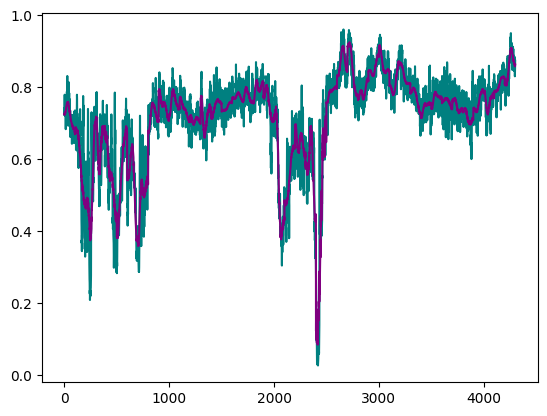

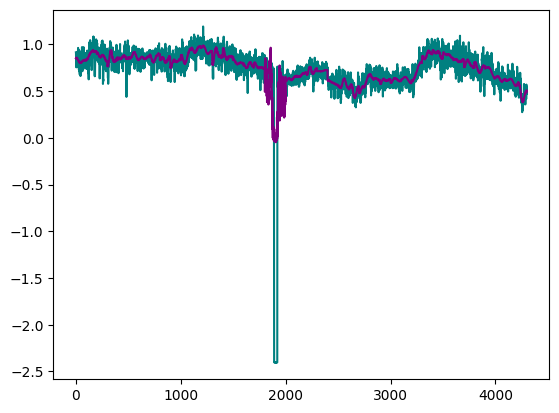

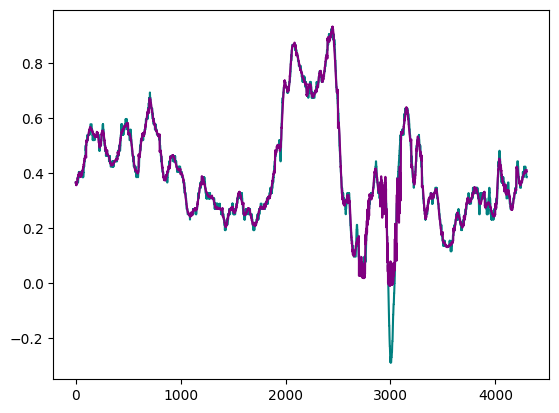

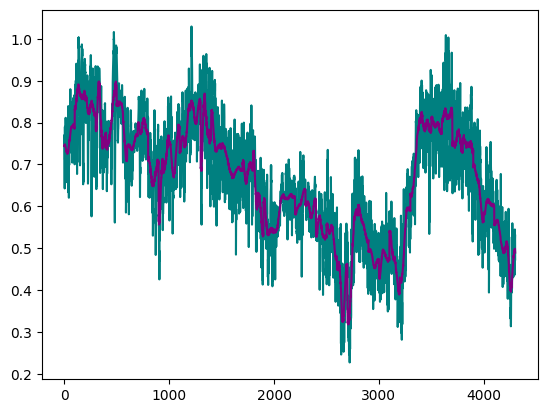

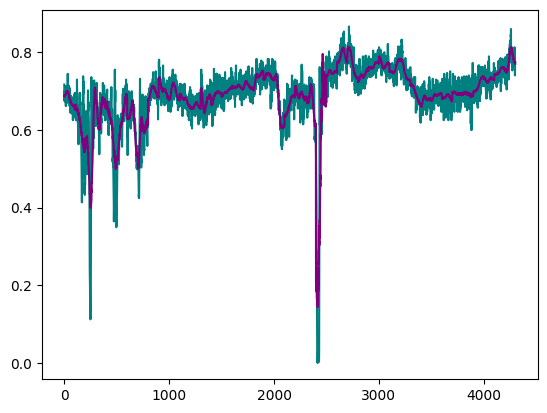

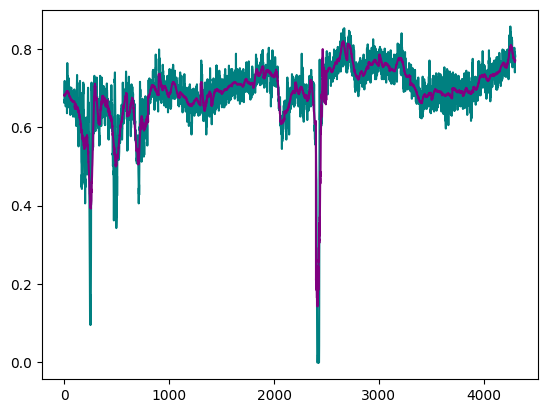

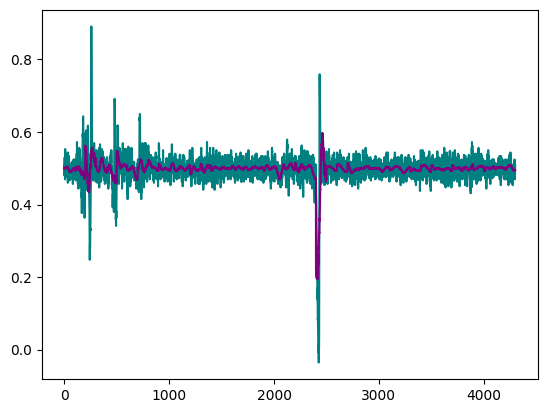

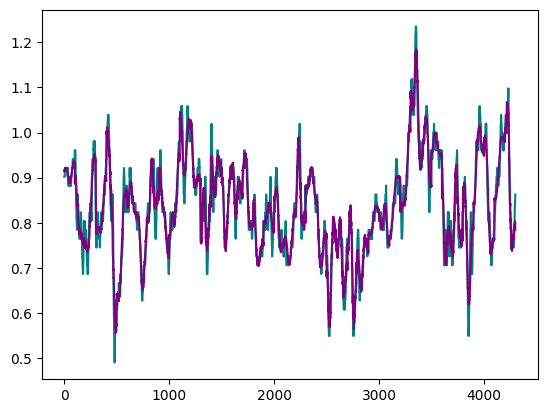

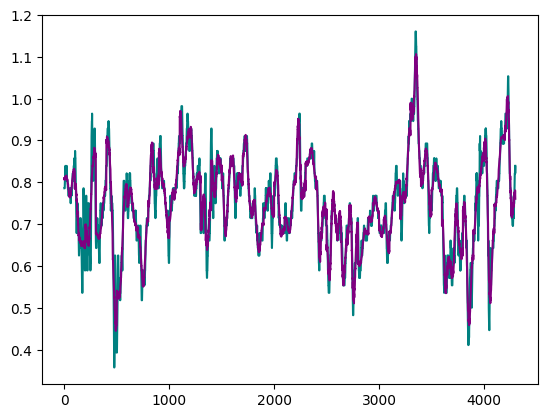

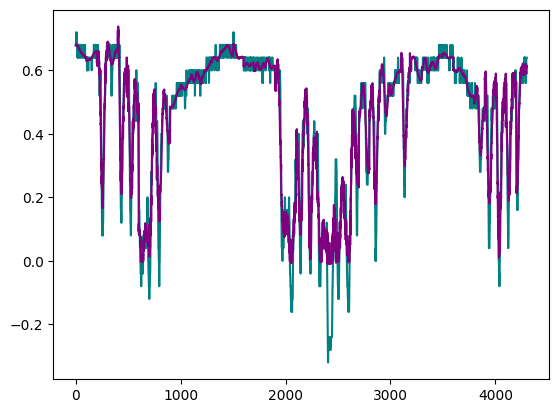

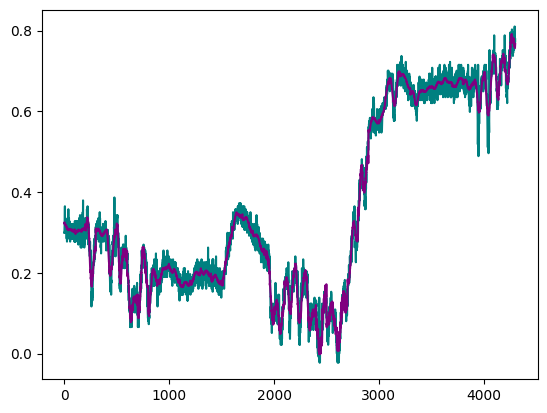

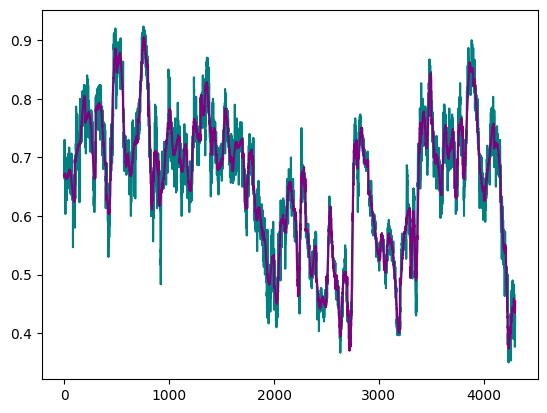

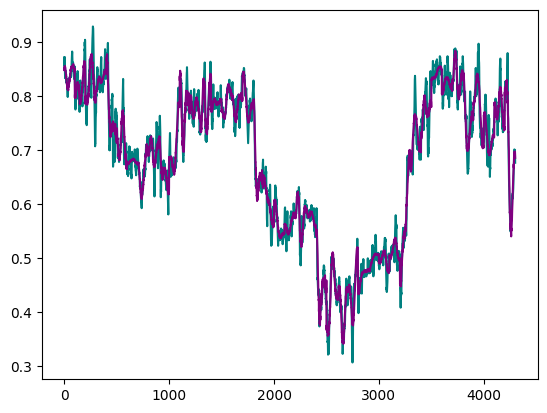

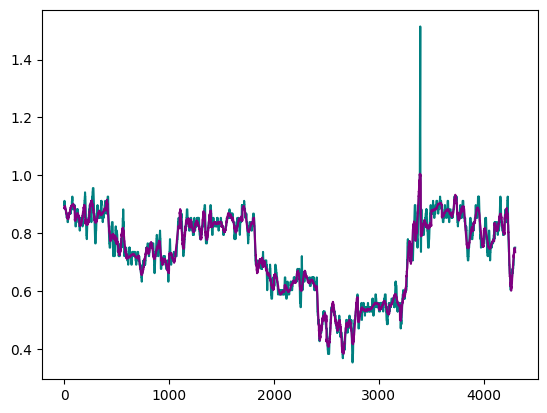

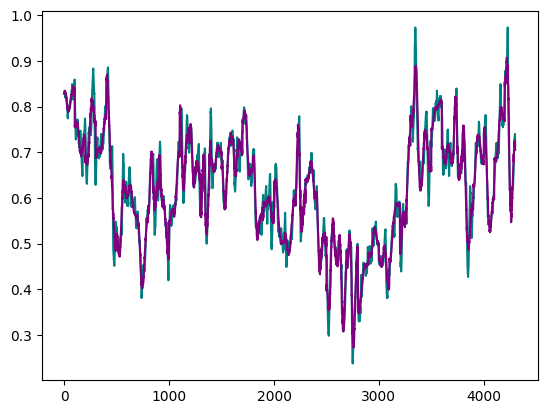

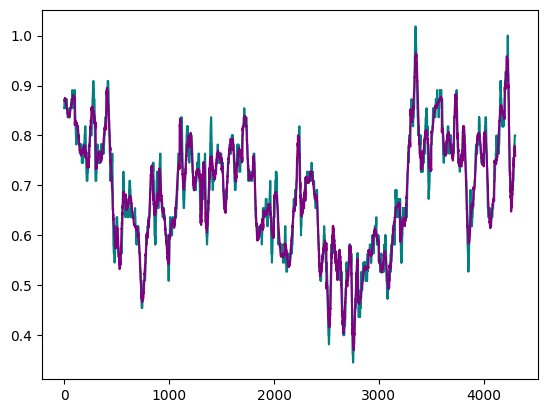

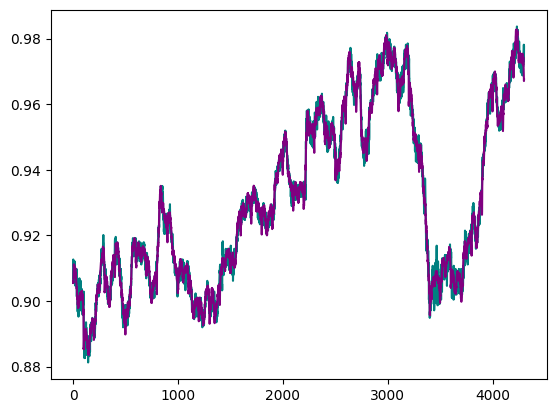

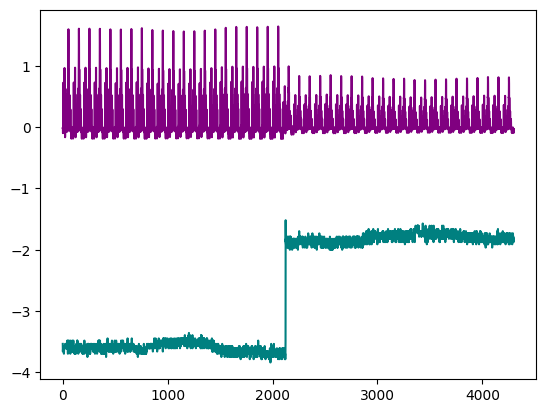

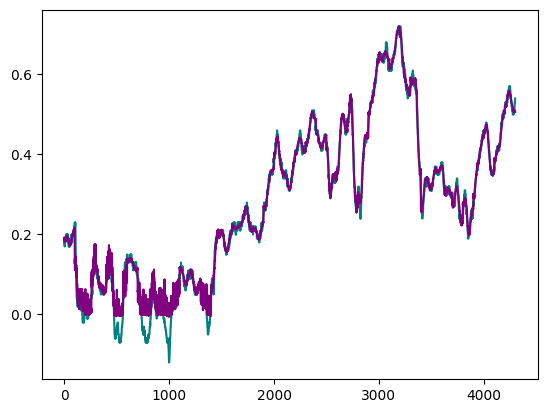

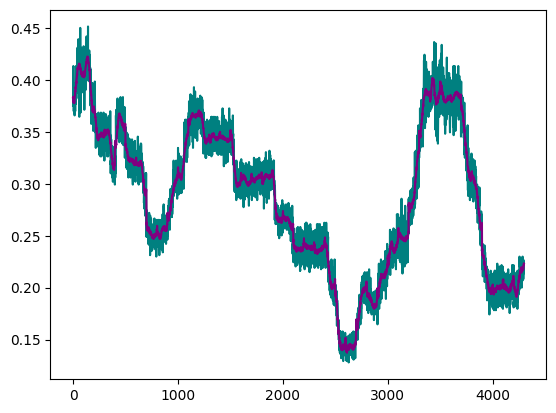

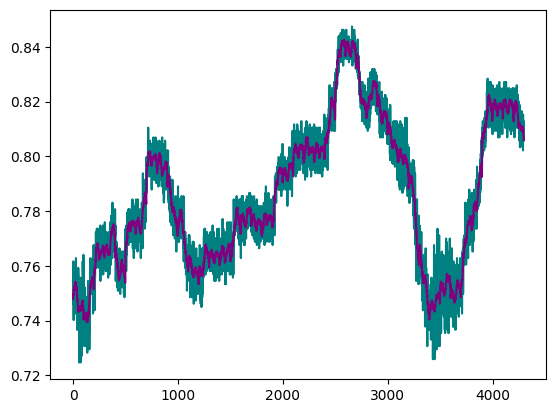

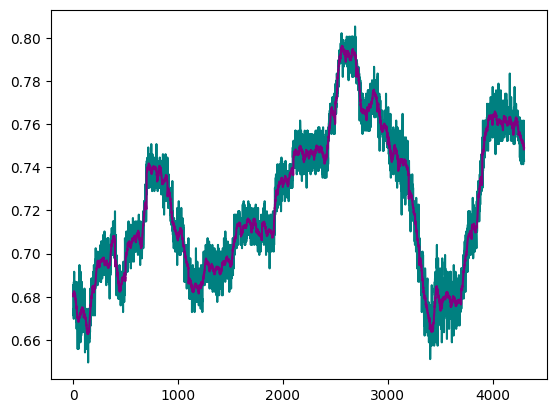

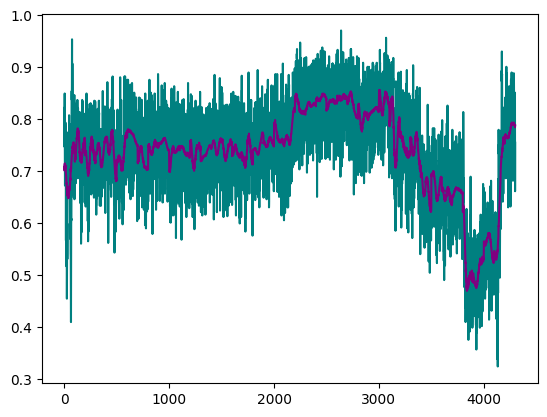

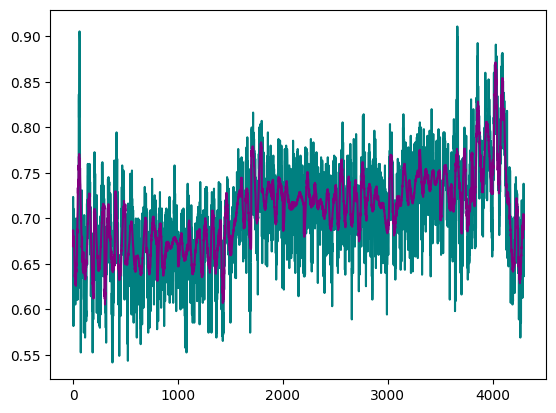

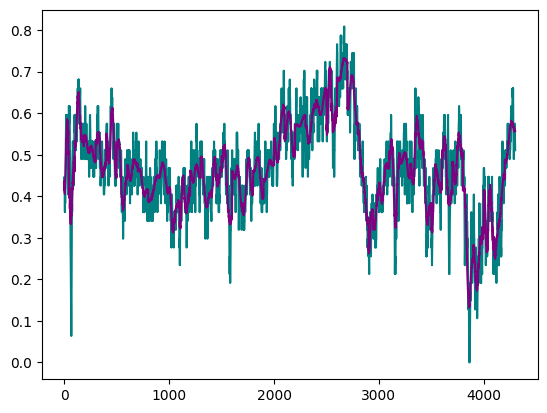

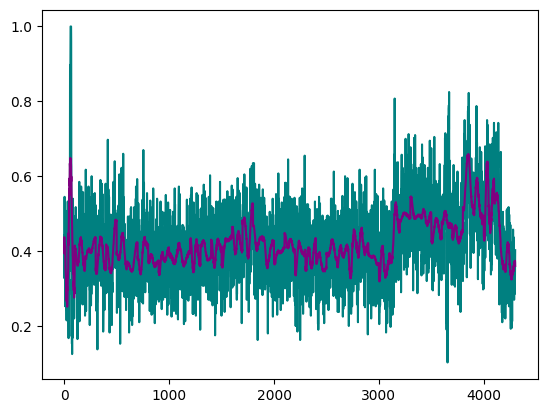

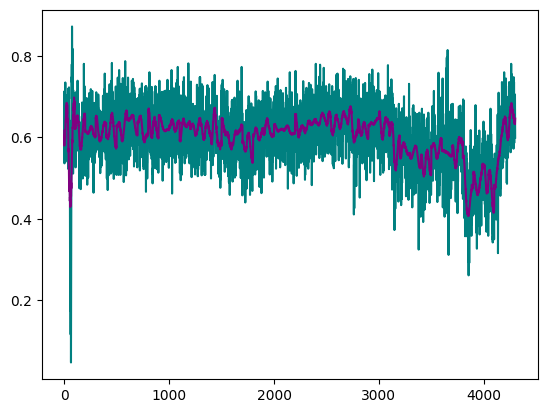

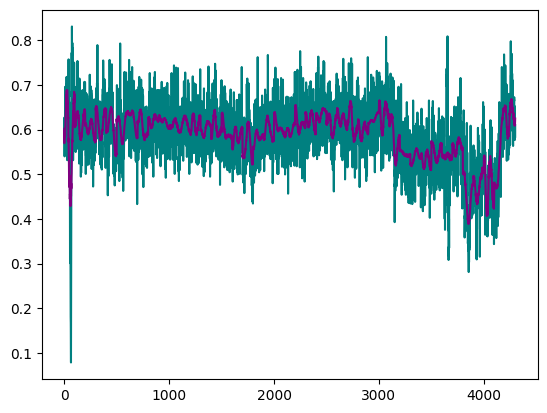

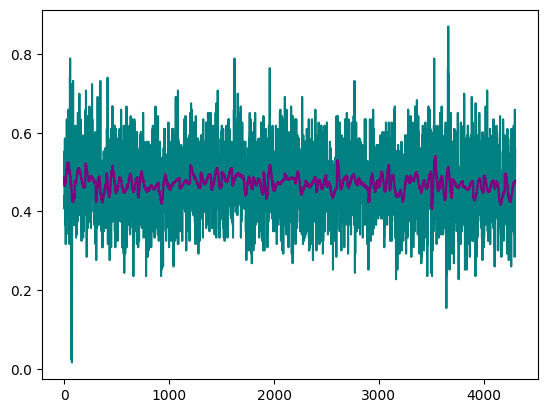

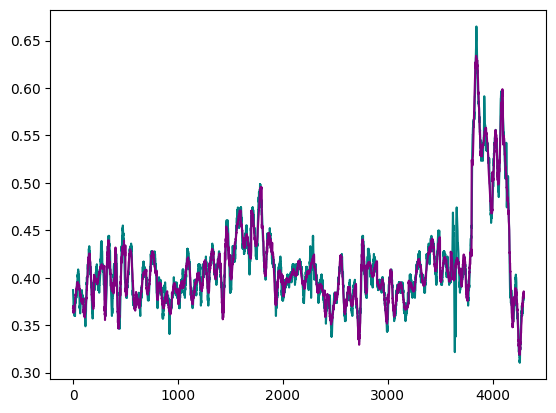

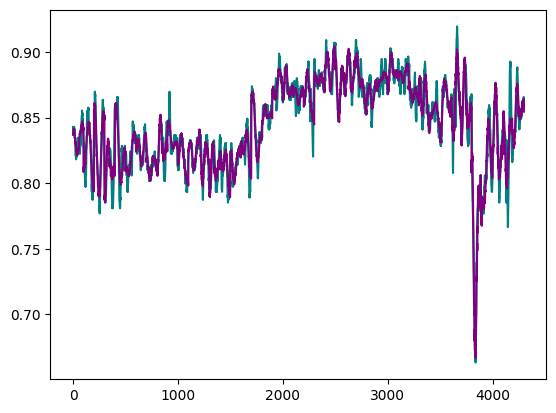

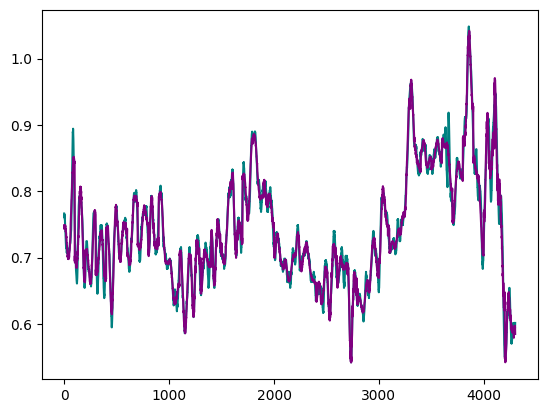

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Encoder + Decocder (current attempt)
for sensor in range(num_sensors):
    pred = np.array(pred)
    truth = np.array(truth)
    plt.plot(truth[:,sensor], color="teal")
    plt.plot(pred[:,sensor], color="purple")
    plt.show()

# Eval Autoencoder (anomalies)

In [13]:
test = torch.FloatTensor(test_dfs[0][::downsample].values)
num_timesteps, num_sensors = test.shape
num_time_windows = num_timesteps//time_window_size
length = num_time_windows*num_sensors

# Linear trend in 1st sensor
transition_point = int(num_timesteps*0.5)
test[transition_point:,0] = test[transition_point:,0] + np.arange(transition_point,num_timesteps)*(1e-4)

# Outlier in 2nd sensor
outlier_start = int(num_timesteps*0.6)
outlier_stop = int(num_timesteps*0.62)
test[outlier_start:outlier_stop,1] = test[outlier_start:outlier_stop,1]*np.random.uniform(low=5, high=6, size=(outlier_stop-outlier_start))


In [14]:
test_dataset = TimewindowDataset(test, time_window_size)
batch_size = 1
test_dataloader = DataLoader(test_dataset, shuffle=False, drop_last=True, batch_size=batch_size)

In [15]:
# Iterate over all (x,y) pairs in validation dataloader
pred  = torch.empty((num_time_windows*time_window_size,num_sensors))
truth_anom = torch.empty((num_time_windows*time_window_size,num_sensors))

with torch.no_grad():
    for i, x in enumerate(test_dataloader):
        if i%100==0:
            print(f"{i}/{len(test_dataloader)}")
        sensor_num = i//num_time_windows
        time_window = i%num_time_windows
        # Make forecasts
        prediction = model(x)

        pred[time_window*time_window_size:(time_window+1)*time_window_size,sensor_num] = prediction
        truth_anom[time_window*time_window_size:(time_window+1)*time_window_size,sensor_num] = x


0/1376
100/1376
200/1376
300/1376
400/1376
500/1376
600/1376
700/1376
800/1376
900/1376
1000/1376
1100/1376
1200/1376
1300/1376


# Visualize Autoencoder (anomalies)

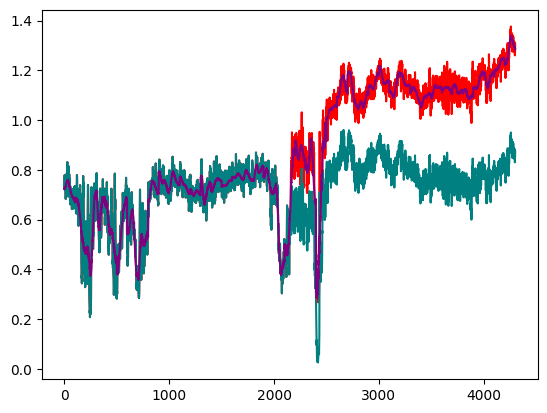

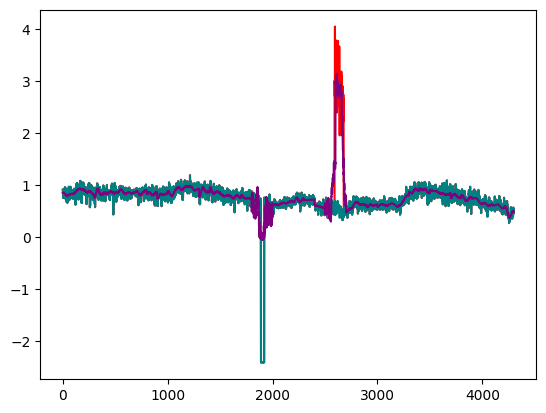

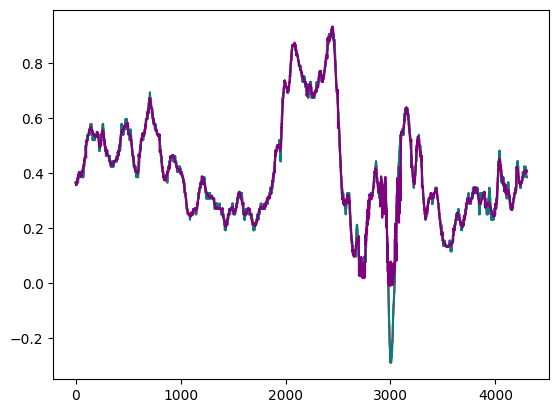

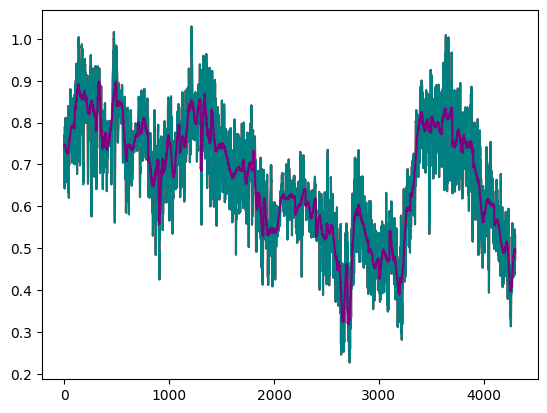

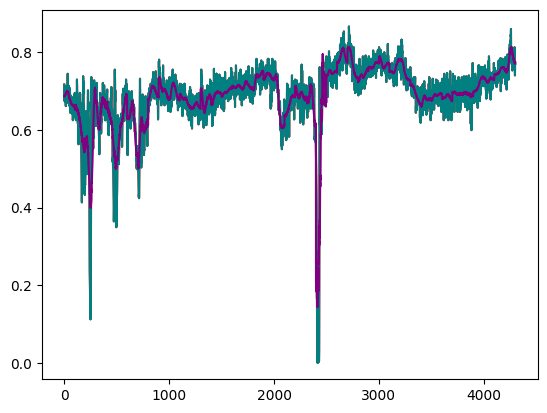

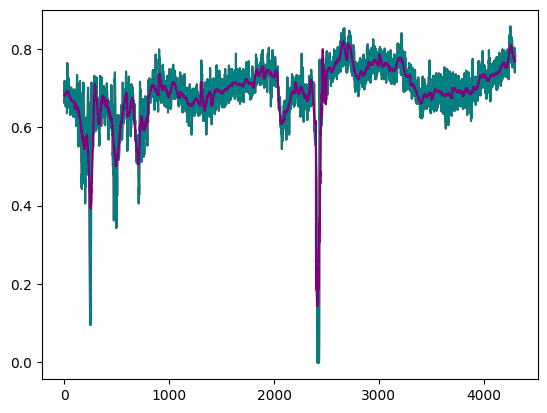

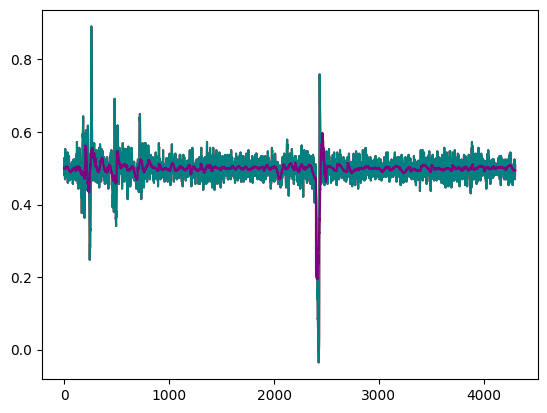

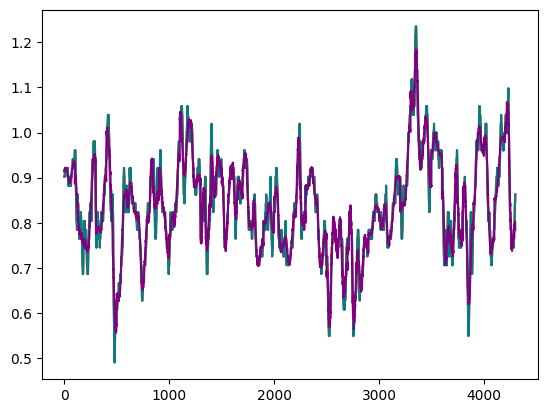

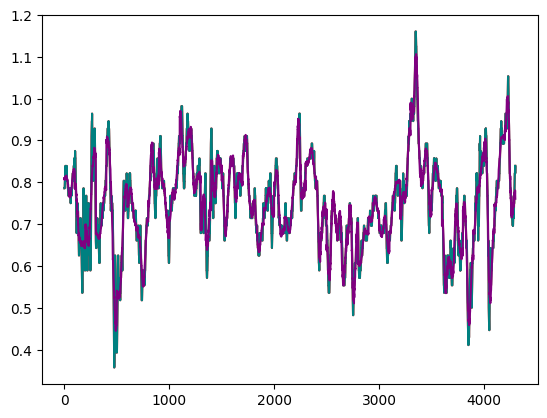

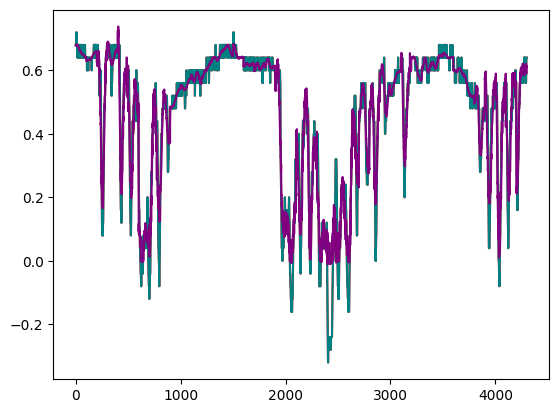

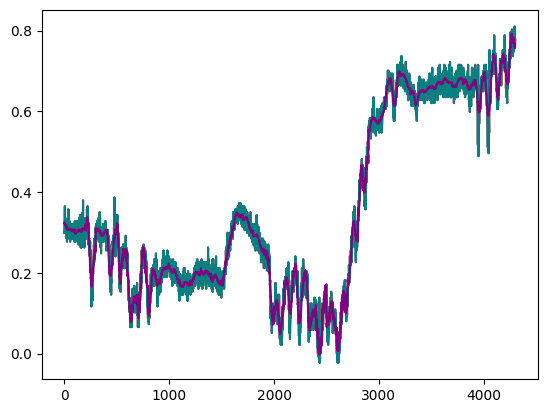

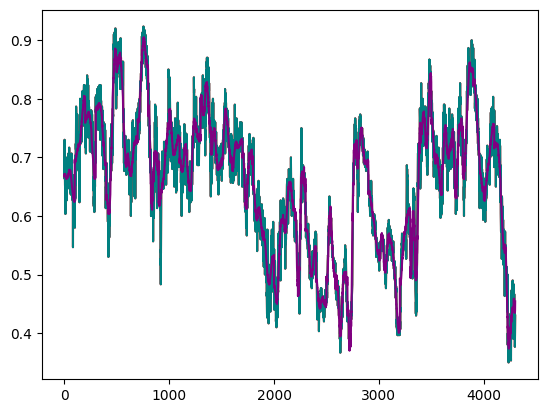

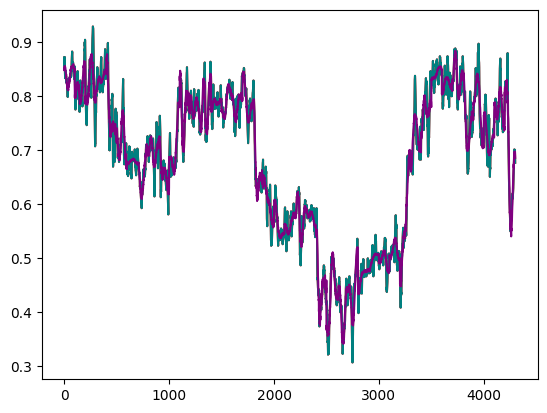

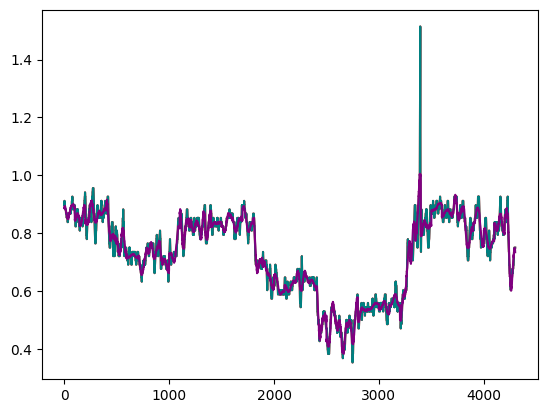

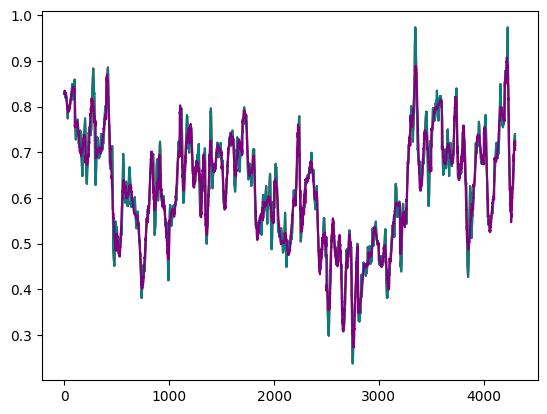

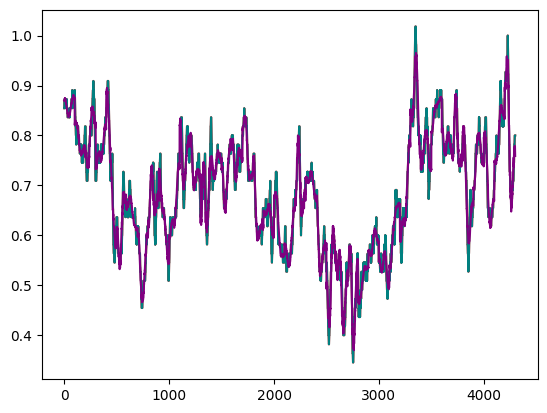

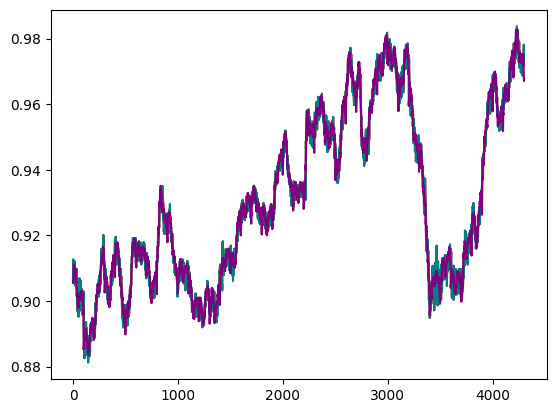

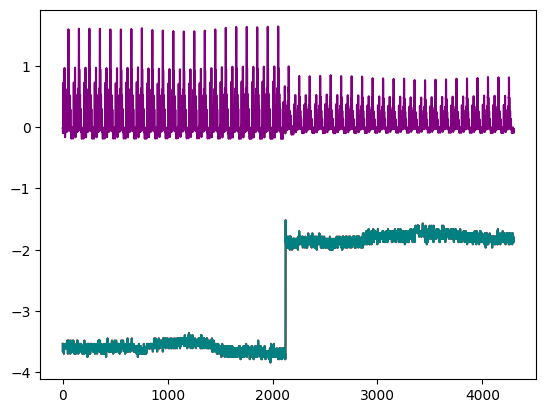

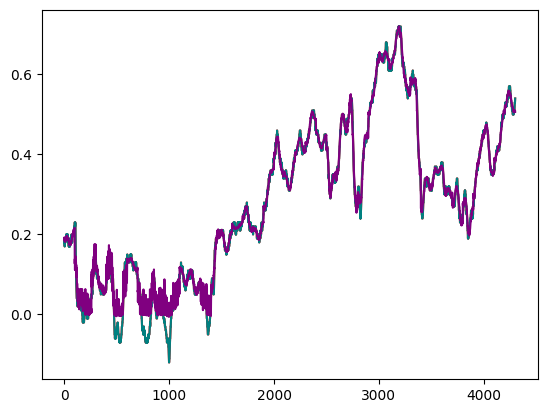

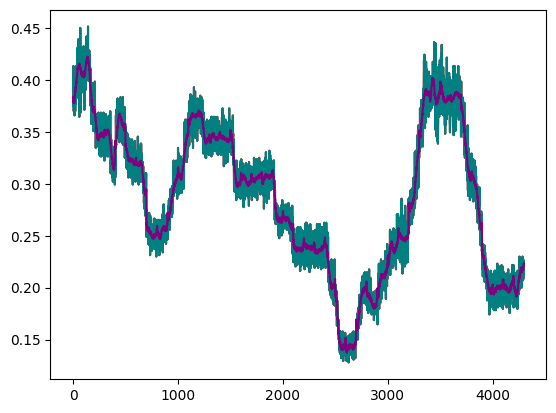

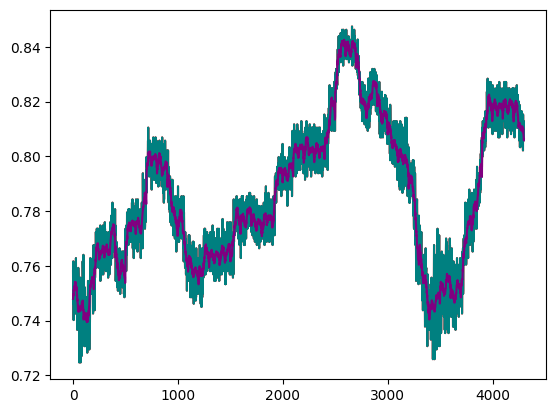

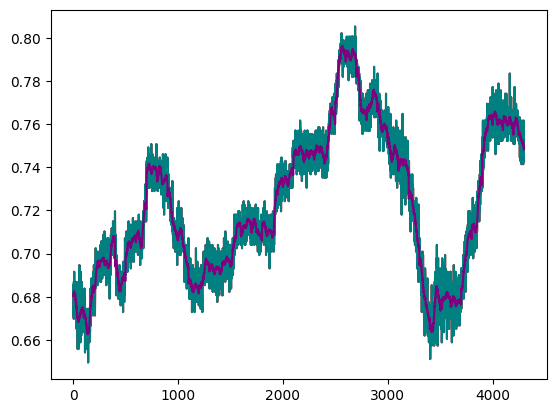

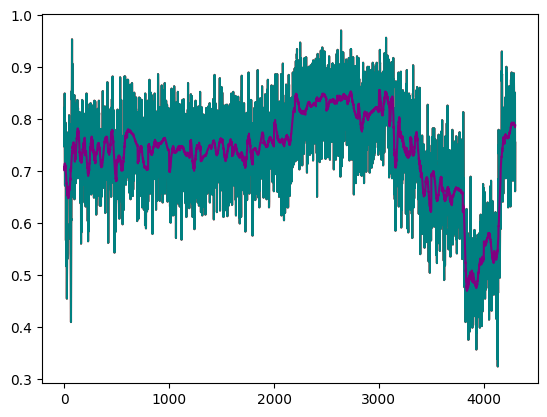

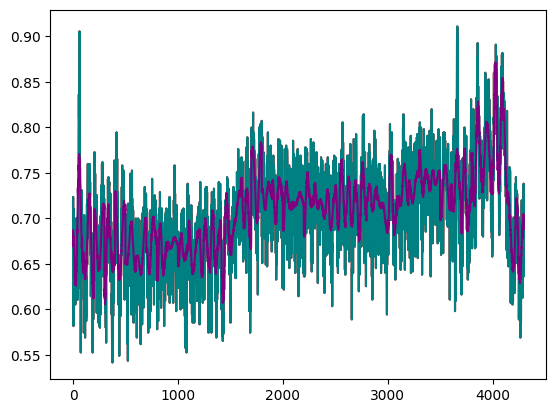

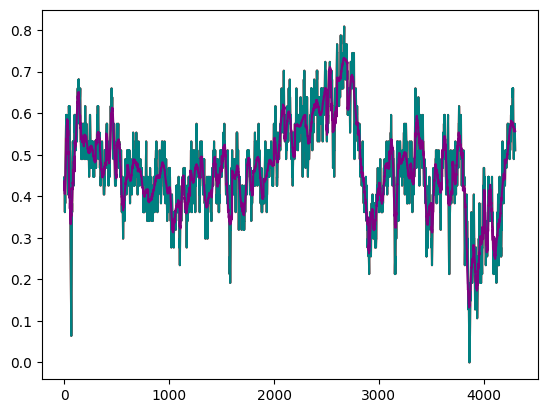

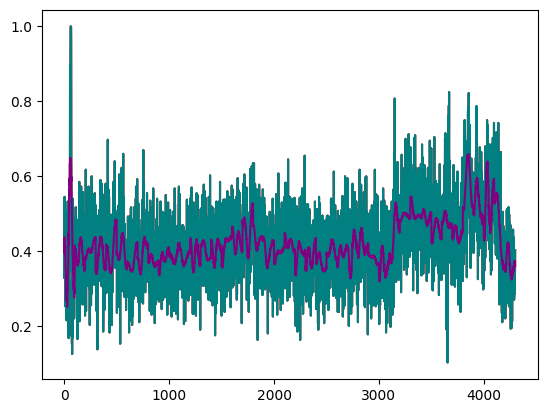

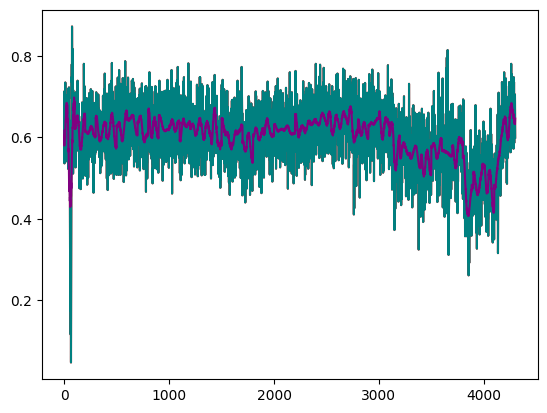

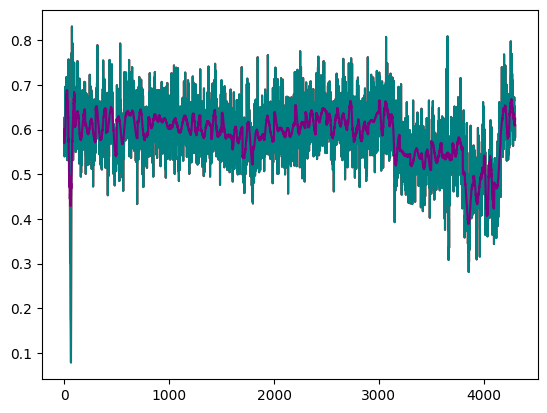

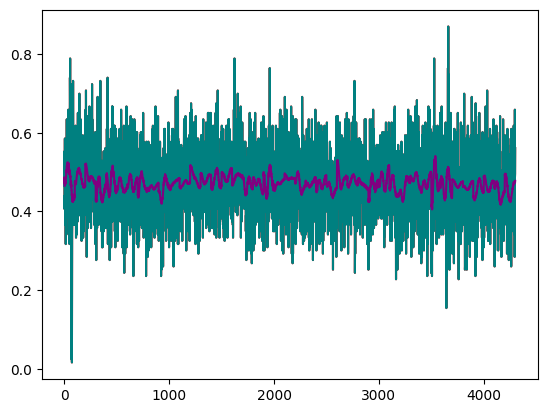

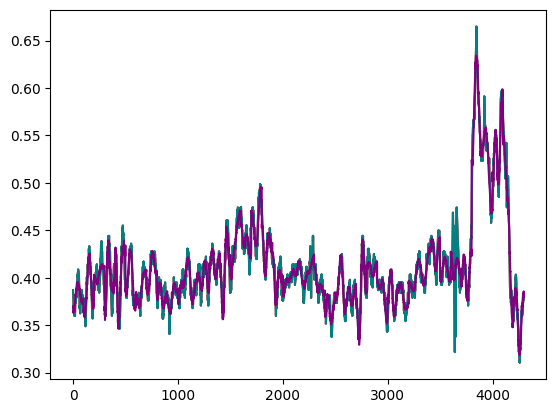

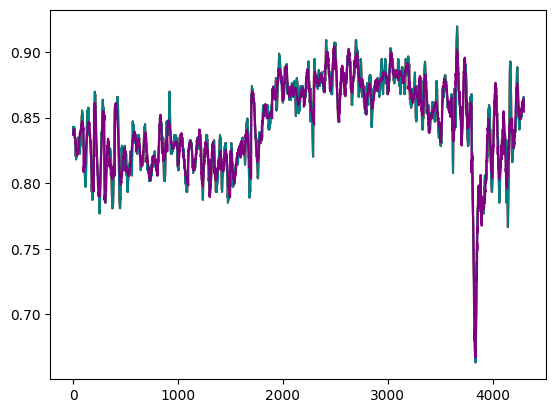

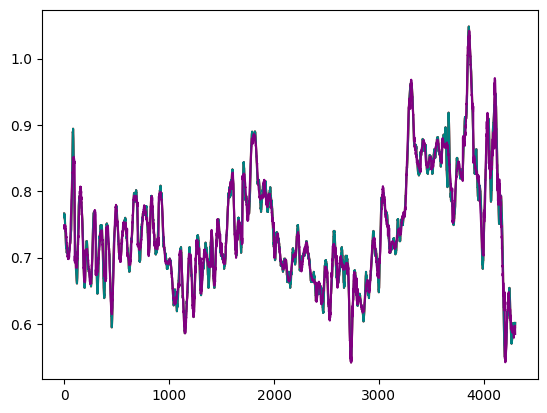

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Encoder + Decocder (current attempt)
for sensor in range(num_sensors):
    pred = np.array(pred)
    truth = np.array(truth)
    plt.plot(truth_anom[:,sensor], color="red")
    plt.plot(truth[:,sensor], color="teal")
    plt.plot(pred[:,sensor], color="purple")
    plt.show()

# VAE

In [180]:
class VariationalEncoder(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden1)
        self.linear2 = nn.Linear(hidden1, hidden2)
        self.linear3 = nn.Linear(hidden2, latent_dims)
        self.linear4 = nn.Linear(hidden2, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc
        self.N.scale = self.N.scale
        self.relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        mu =  self.relu(self.linear3(x)) # mean across each dimension in latent space
        sigma = torch.exp(self.relu(self.linear4(x))) # covar across each dimension in latent space
        z = mu + sigma*self.N.sample(mu.shape)
        kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z, kl

In [181]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.variational_encoder = VariationalEncoder(input_size, hidden1, hidden2, latent_dims)
        self.decoder = Decoder(input_size, hidden1, hidden2, latent_dims)

    def forward(self, x):
        x, kl = self.variational_encoder(x)
        x = self.decoder(x)
        return x, kl

# Train VAE

In [200]:
downsample = 20
train = torch.FloatTensor(train_dfs[::downsample].values)
num_sensors = train.shape[1]

batch_size = 400
time_window_size = 25
train_dataset = TimewindowDataset(train, time_window_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, drop_last=True, shuffle=False)

num_timesteps, num_sensors = train.shape
num_time_windows = num_timesteps//time_window_size
length = num_time_windows*num_sensors

In [201]:
epochs = 3000

model = VariationalAutoencoder(
    input_size=time_window_size,
    hidden1=time_window_size,
    hidden2=time_window_size//2,
    latent_dims=time_window_size//4
)

lr=1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss(reduction="sum") # reduction=sum, none, mean

start = time.time()

for epoch in range(epochs):
    for i, x in enumerate(train_dataloader):
        sensor_num = i//num_time_windows
        #if sensor_num==0:
        optimizer.zero_grad()
        z,kl = model(x)
        loss = criterion(z,x)+kl
        loss.backward()
        optimizer.step()

        if i%1000 == 0:
            print(f"Epoch {epoch}, item {i}/{len(train_dataloader)}, loss {loss.item()}")        

end = time.time()
print(f"training time: {end-start}")

Epoch 0, item 0/55, loss 6391.91552734375
Epoch 1, item 0/55, loss 6141.72119140625
Epoch 2, item 0/55, loss 5890.20703125
Epoch 3, item 0/55, loss 5540.87353515625
Epoch 4, item 0/55, loss 5132.71240234375
Epoch 5, item 0/55, loss 4618.537109375
Epoch 6, item 0/55, loss 3997.513671875
Epoch 7, item 0/55, loss 3494.933349609375
Epoch 8, item 0/55, loss 3022.986328125
Epoch 9, item 0/55, loss 2619.4267578125
Epoch 10, item 0/55, loss 2338.78076171875
Epoch 11, item 0/55, loss 2133.18603515625
Epoch 12, item 0/55, loss 1928.8624267578125
Epoch 13, item 0/55, loss 1785.548828125
Epoch 14, item 0/55, loss 1620.1458740234375
Epoch 15, item 0/55, loss 1558.612548828125
Epoch 16, item 0/55, loss 1512.9698486328125
Epoch 17, item 0/55, loss 1458.666748046875
Epoch 18, item 0/55, loss 1400.718017578125
Epoch 19, item 0/55, loss 1340.2789306640625
Epoch 20, item 0/55, loss 1312.05615234375
Epoch 21, item 0/55, loss 1319.74072265625
Epoch 22, item 0/55, loss 1286.8121337890625
Epoch 23, item 0/55

Epoch 186, item 0/55, loss 1101.15576171875
Epoch 187, item 0/55, loss 1099.54931640625
Epoch 188, item 0/55, loss 1095.101318359375
Epoch 189, item 0/55, loss 1089.7333984375
Epoch 190, item 0/55, loss 1091.7716064453125
Epoch 191, item 0/55, loss 1097.932861328125
Epoch 192, item 0/55, loss 1095.291259765625
Epoch 193, item 0/55, loss 1091.0126953125
Epoch 194, item 0/55, loss 1101.237060546875
Epoch 195, item 0/55, loss 1098.092529296875
Epoch 196, item 0/55, loss 1098.465576171875
Epoch 197, item 0/55, loss 1098.69091796875
Epoch 198, item 0/55, loss 1095.9326171875
Epoch 199, item 0/55, loss 1095.6737060546875
Epoch 200, item 0/55, loss 1098.009765625
Epoch 201, item 0/55, loss 1085.0106201171875
Epoch 202, item 0/55, loss 1094.2364501953125
Epoch 203, item 0/55, loss 1095.95068359375
Epoch 204, item 0/55, loss 1098.841552734375
Epoch 205, item 0/55, loss 1101.53759765625
Epoch 206, item 0/55, loss 1094.3023681640625
Epoch 207, item 0/55, loss 1098.67236328125
Epoch 208, item 0/55

Epoch 372, item 0/55, loss 1093.70458984375
Epoch 373, item 0/55, loss 1087.1668701171875
Epoch 374, item 0/55, loss 1092.5999755859375
Epoch 375, item 0/55, loss 1097.8704833984375
Epoch 376, item 0/55, loss 1075.93603515625
Epoch 377, item 0/55, loss 1064.75732421875
Epoch 378, item 0/55, loss 1079.24560546875
Epoch 379, item 0/55, loss 1095.55322265625
Epoch 380, item 0/55, loss 1096.164794921875
Epoch 381, item 0/55, loss 1096.4769287109375
Epoch 382, item 0/55, loss 1072.92236328125
Epoch 383, item 0/55, loss 1082.558349609375
Epoch 384, item 0/55, loss 1081.891357421875
Epoch 385, item 0/55, loss 1095.0853271484375
Epoch 386, item 0/55, loss 1104.7803955078125
Epoch 387, item 0/55, loss 1104.0166015625
Epoch 388, item 0/55, loss 1089.020751953125
Epoch 389, item 0/55, loss 1074.2783203125
Epoch 390, item 0/55, loss 1088.7039794921875
Epoch 391, item 0/55, loss 1080.93798828125
Epoch 392, item 0/55, loss 1092.121337890625
Epoch 393, item 0/55, loss 1085.3746337890625
Epoch 394, it

Epoch 555, item 0/55, loss 1069.4945068359375
Epoch 556, item 0/55, loss 1094.64111328125
Epoch 557, item 0/55, loss 1088.2176513671875
Epoch 558, item 0/55, loss 1057.48193359375
Epoch 559, item 0/55, loss 1083.609375
Epoch 560, item 0/55, loss 1060.8365478515625
Epoch 561, item 0/55, loss 1066.3096923828125
Epoch 562, item 0/55, loss 1083.9737548828125
Epoch 563, item 0/55, loss 1077.2247314453125
Epoch 564, item 0/55, loss 1083.4921875
Epoch 565, item 0/55, loss 1080.7371826171875
Epoch 566, item 0/55, loss 1078.7816162109375
Epoch 567, item 0/55, loss 1071.193115234375
Epoch 568, item 0/55, loss 1085.43212890625
Epoch 569, item 0/55, loss 1056.5958251953125
Epoch 570, item 0/55, loss 1065.849853515625
Epoch 571, item 0/55, loss 1080.02587890625
Epoch 572, item 0/55, loss 1084.4920654296875
Epoch 573, item 0/55, loss 1080.407470703125
Epoch 574, item 0/55, loss 1070.5850830078125
Epoch 575, item 0/55, loss 1056.8724365234375
Epoch 576, item 0/55, loss 1082.83984375
Epoch 577, item 0

Epoch 738, item 0/55, loss 1083.056396484375
Epoch 739, item 0/55, loss 1086.115234375
Epoch 740, item 0/55, loss 1083.163818359375
Epoch 741, item 0/55, loss 1079.5889892578125
Epoch 742, item 0/55, loss 1073.14892578125
Epoch 743, item 0/55, loss 1079.064697265625
Epoch 744, item 0/55, loss 1082.73876953125
Epoch 745, item 0/55, loss 1078.4033203125
Epoch 746, item 0/55, loss 1082.103759765625
Epoch 747, item 0/55, loss 1096.8719482421875
Epoch 748, item 0/55, loss 1071.158447265625
Epoch 749, item 0/55, loss 1064.626953125
Epoch 750, item 0/55, loss 1082.3485107421875
Epoch 751, item 0/55, loss 1084.567138671875
Epoch 752, item 0/55, loss 1070.8602294921875
Epoch 753, item 0/55, loss 1094.7626953125
Epoch 754, item 0/55, loss 1082.5557861328125
Epoch 755, item 0/55, loss 1091.2406005859375
Epoch 756, item 0/55, loss 1078.8782958984375
Epoch 757, item 0/55, loss 1092.4619140625
Epoch 758, item 0/55, loss 1074.6104736328125
Epoch 759, item 0/55, loss 1072.2581787109375
Epoch 760, item

Epoch 921, item 0/55, loss 1075.220703125
Epoch 922, item 0/55, loss 1092.5836181640625
Epoch 923, item 0/55, loss 1072.1505126953125
Epoch 924, item 0/55, loss 1064.276123046875
Epoch 925, item 0/55, loss 1074.78955078125
Epoch 926, item 0/55, loss 1074.5335693359375
Epoch 927, item 0/55, loss 1088.9947509765625
Epoch 928, item 0/55, loss 1089.0089111328125
Epoch 929, item 0/55, loss 1066.5477294921875
Epoch 930, item 0/55, loss 1087.5849609375
Epoch 931, item 0/55, loss 1077.2593994140625
Epoch 932, item 0/55, loss 1095.873046875
Epoch 933, item 0/55, loss 1086.4766845703125
Epoch 934, item 0/55, loss 1101.5201416015625
Epoch 935, item 0/55, loss 1093.7391357421875
Epoch 936, item 0/55, loss 1096.828369140625
Epoch 937, item 0/55, loss 1073.5482177734375
Epoch 938, item 0/55, loss 1074.4300537109375
Epoch 939, item 0/55, loss 1079.765380859375
Epoch 940, item 0/55, loss 1082.510009765625
Epoch 941, item 0/55, loss 1070.5982666015625
Epoch 942, item 0/55, loss 1084.354248046875
Epoch 

Epoch 1104, item 0/55, loss 1075.722412109375
Epoch 1105, item 0/55, loss 1074.9066162109375
Epoch 1106, item 0/55, loss 1072.518798828125
Epoch 1107, item 0/55, loss 1087.3206787109375
Epoch 1108, item 0/55, loss 1083.03515625
Epoch 1109, item 0/55, loss 1089.9124755859375
Epoch 1110, item 0/55, loss 1107.014892578125
Epoch 1111, item 0/55, loss 1115.529296875
Epoch 1112, item 0/55, loss 1082.4228515625
Epoch 1113, item 0/55, loss 1060.6693115234375
Epoch 1114, item 0/55, loss 1068.461669921875
Epoch 1115, item 0/55, loss 1087.1739501953125
Epoch 1116, item 0/55, loss 1093.143798828125
Epoch 1117, item 0/55, loss 1081.198974609375
Epoch 1118, item 0/55, loss 1062.671142578125
Epoch 1119, item 0/55, loss 1086.3917236328125
Epoch 1120, item 0/55, loss 1083.4842529296875
Epoch 1121, item 0/55, loss 1082.42236328125
Epoch 1122, item 0/55, loss 1073.7886962890625
Epoch 1123, item 0/55, loss 1087.4259033203125
Epoch 1124, item 0/55, loss 1087.642578125
Epoch 1125, item 0/55, loss 1067.16857

Epoch 1284, item 0/55, loss 1066.89501953125
Epoch 1285, item 0/55, loss 1080.359130859375
Epoch 1286, item 0/55, loss 1073.6688232421875
Epoch 1287, item 0/55, loss 1095.6048583984375
Epoch 1288, item 0/55, loss 1082.3687744140625
Epoch 1289, item 0/55, loss 1085.16064453125
Epoch 1290, item 0/55, loss 1072.8497314453125
Epoch 1291, item 0/55, loss 1081.282958984375
Epoch 1292, item 0/55, loss 1093.5626220703125
Epoch 1293, item 0/55, loss 1072.9427490234375
Epoch 1294, item 0/55, loss 1095.640380859375
Epoch 1295, item 0/55, loss 1087.0084228515625
Epoch 1296, item 0/55, loss 1083.30859375
Epoch 1297, item 0/55, loss 1071.1488037109375
Epoch 1298, item 0/55, loss 1088.05029296875
Epoch 1299, item 0/55, loss 1076.2113037109375
Epoch 1300, item 0/55, loss 1072.174560546875
Epoch 1301, item 0/55, loss 1103.88525390625
Epoch 1302, item 0/55, loss 1085.4306640625
Epoch 1303, item 0/55, loss 1082.1595458984375
Epoch 1304, item 0/55, loss 1082.291259765625
Epoch 1305, item 0/55, loss 1085.8

KeyboardInterrupt: 

# Eval VAE (nominal)

In [202]:
test = torch.FloatTensor(test_dfs[0][::downsample].values)
test_dataset = TimewindowDataset(test, time_window_size)
batch_size = 1
test_dataloader = DataLoader(test_dataset, shuffle=False, drop_last=True, batch_size=batch_size)

num_timesteps, num_sensors = test.shape
num_time_windows = num_timesteps//time_window_size
length = num_time_windows*num_sensors

In [203]:
# Iterate over all (x,y) pairs in validation dataloader
pred  = torch.empty((num_time_windows*time_window_size,num_sensors))
truth = torch.empty((num_time_windows*time_window_size,num_sensors))

with torch.no_grad():
    for i, x in enumerate(test_dataloader):
        if i%100==0:
            print(f"{i}/{len(test_dataloader)}")
        sensor_num = i//num_time_windows
        time_window = i%num_time_windows
        
        #if sensor_num == 0:
        # Make forecasts
        prediction,_ = model(x)

        pred[time_window*time_window_size:(time_window+1)*time_window_size,sensor_num] = prediction
        truth[time_window*time_window_size:(time_window+1)*time_window_size,sensor_num] = x


0/5504
100/5504
200/5504
300/5504
400/5504
500/5504
600/5504
700/5504
800/5504
900/5504
1000/5504
1100/5504
1200/5504
1300/5504
1400/5504
1500/5504
1600/5504
1700/5504
1800/5504
1900/5504
2000/5504
2100/5504
2200/5504
2300/5504
2400/5504
2500/5504
2600/5504
2700/5504
2800/5504
2900/5504
3000/5504
3100/5504
3200/5504
3300/5504
3400/5504
3500/5504
3600/5504
3700/5504
3800/5504
3900/5504
4000/5504
4100/5504
4200/5504
4300/5504
4400/5504
4500/5504
4600/5504
4700/5504
4800/5504
4900/5504
5000/5504
5100/5504
5200/5504
5300/5504
5400/5504
5500/5504


# Visualize VAE (nominal inference)

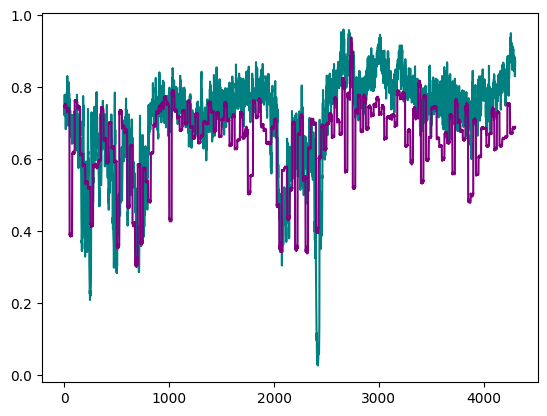

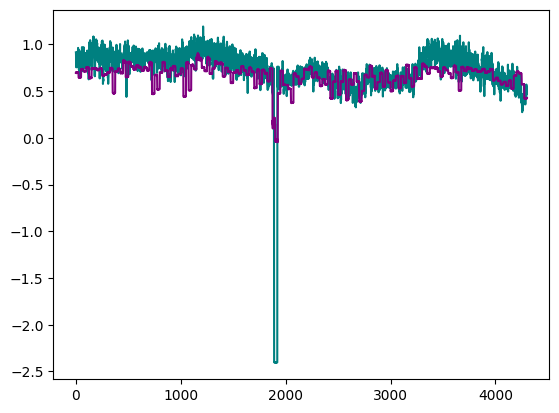

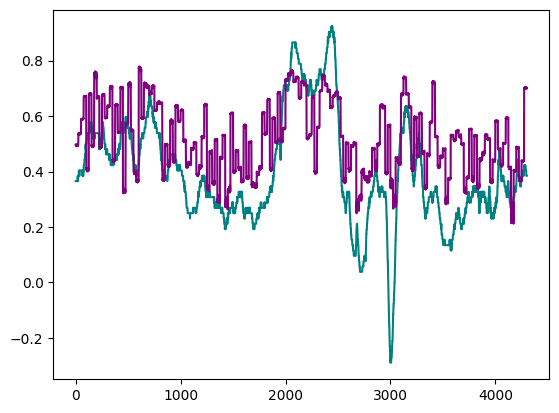

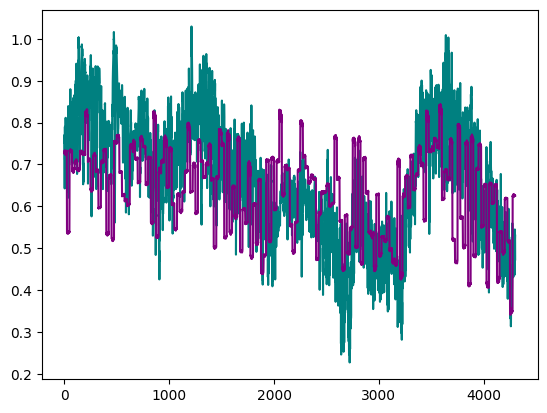

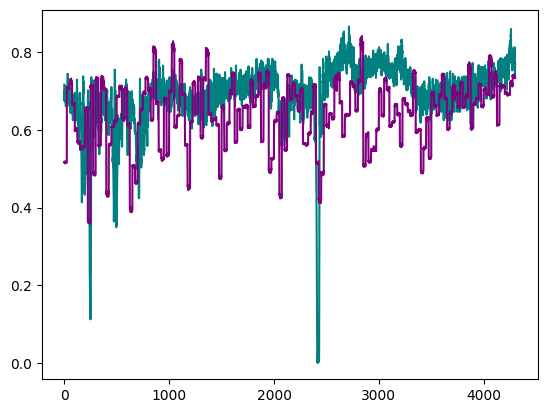

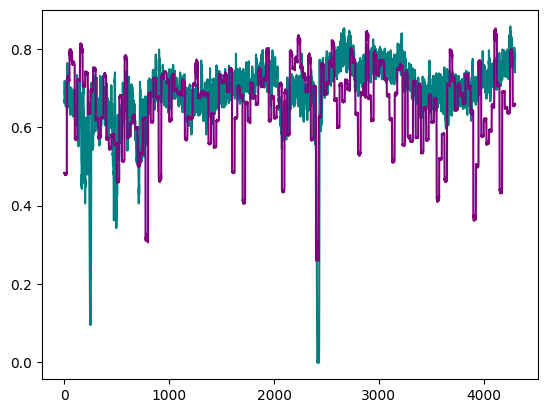

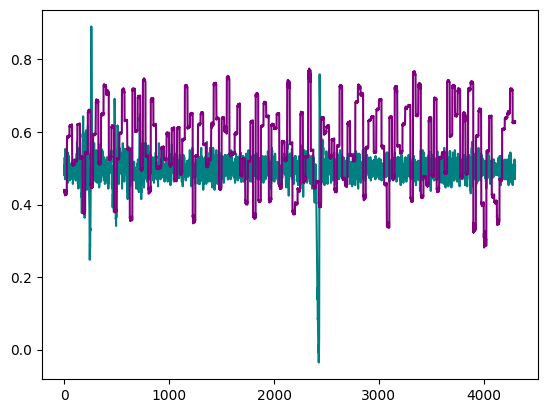

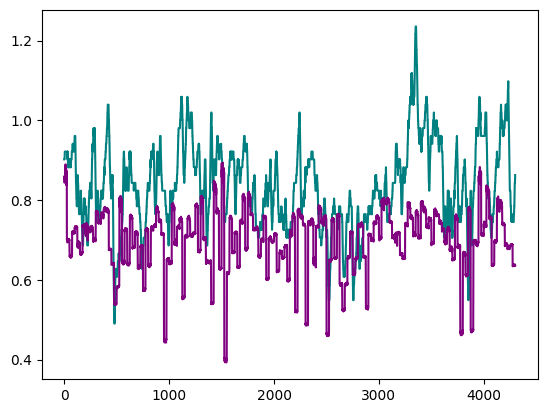

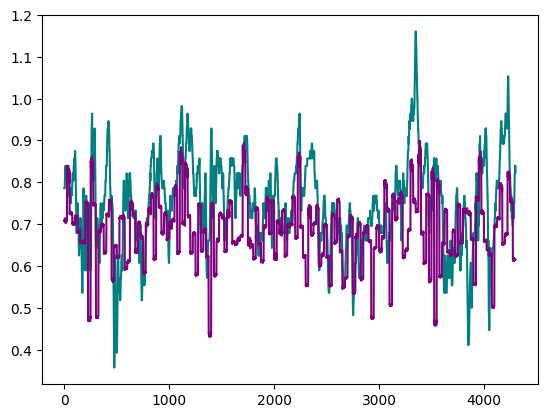

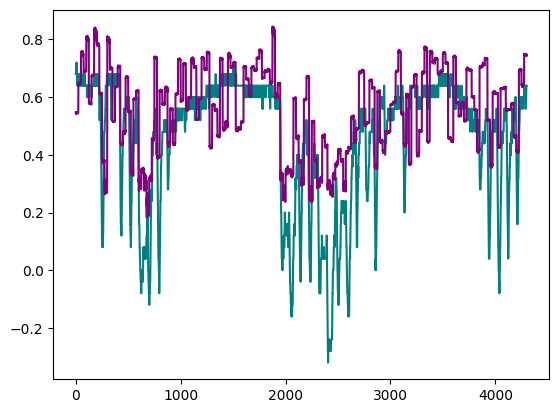

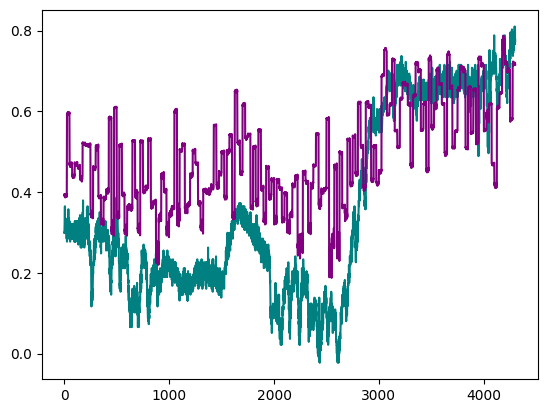

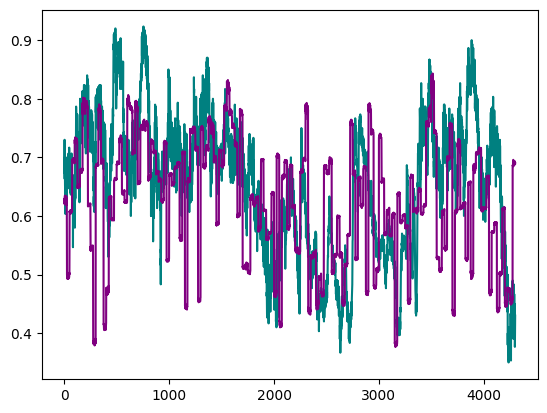

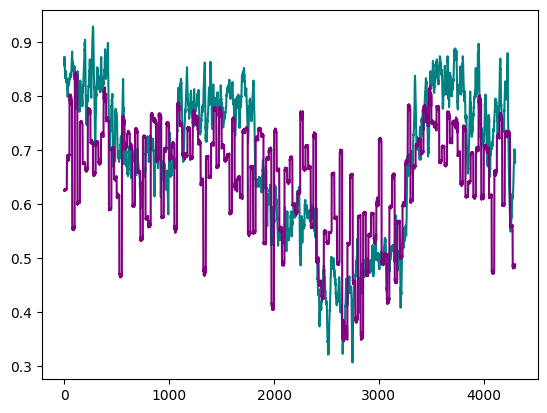

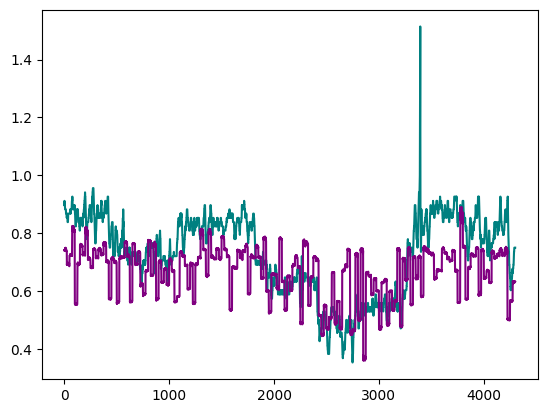

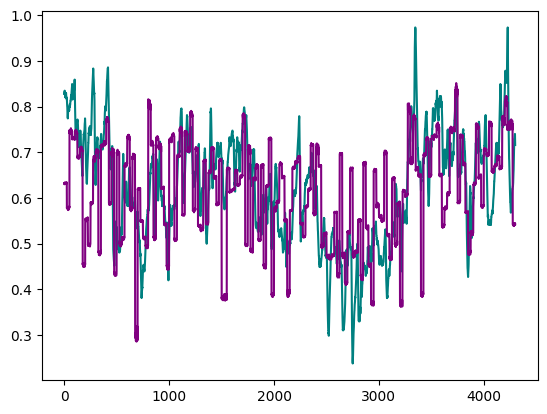

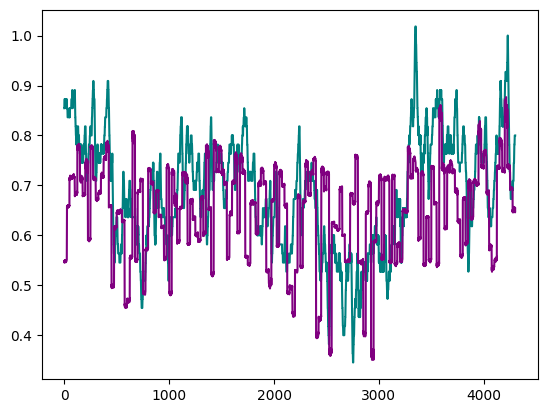

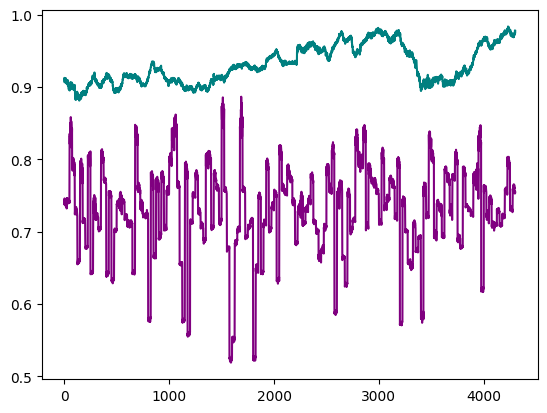

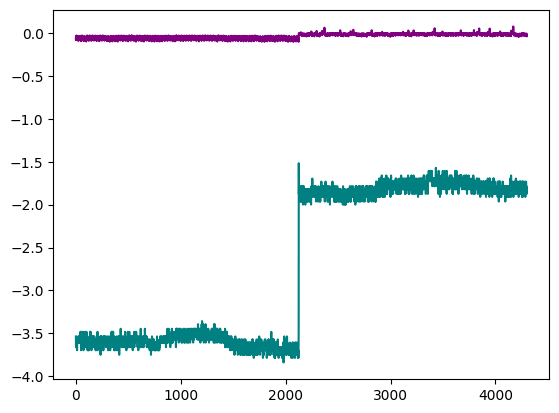

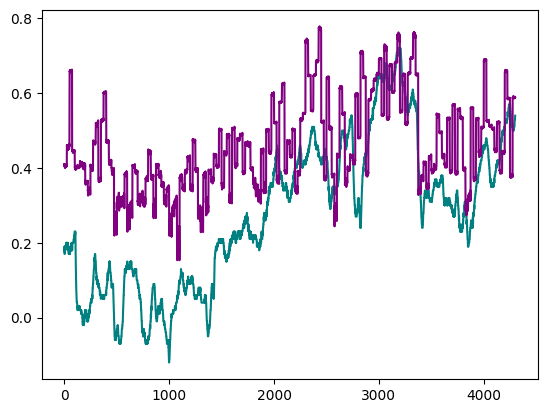

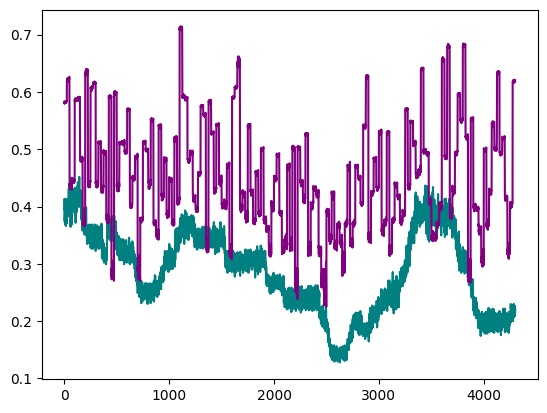

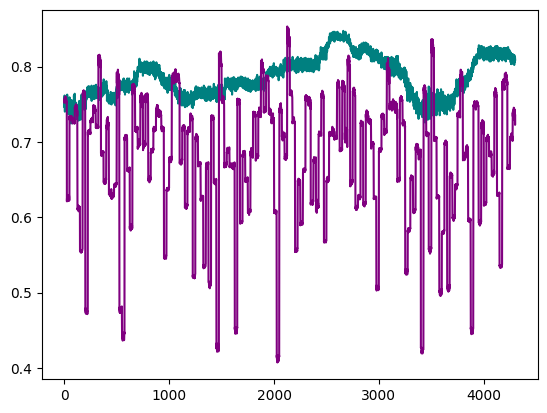

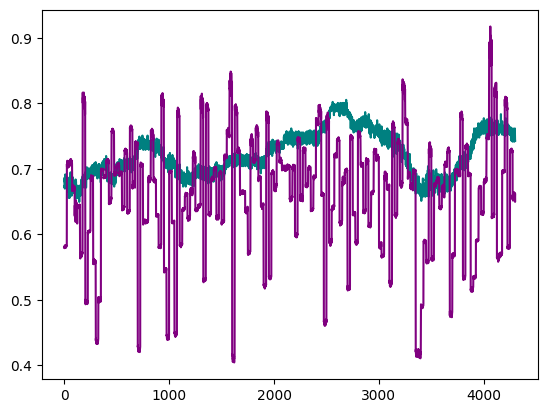

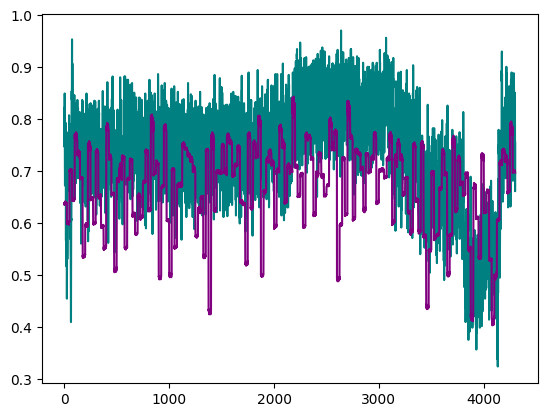

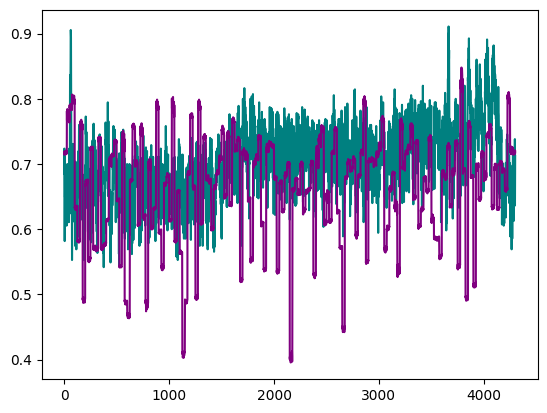

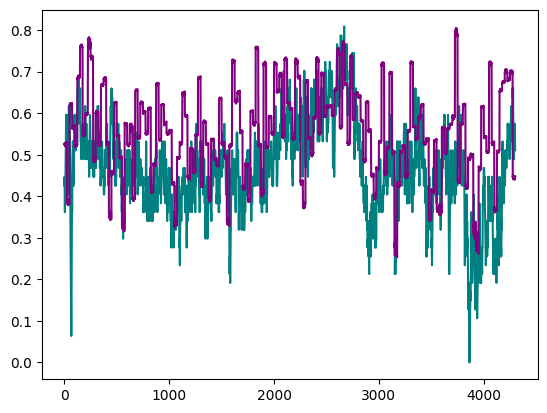

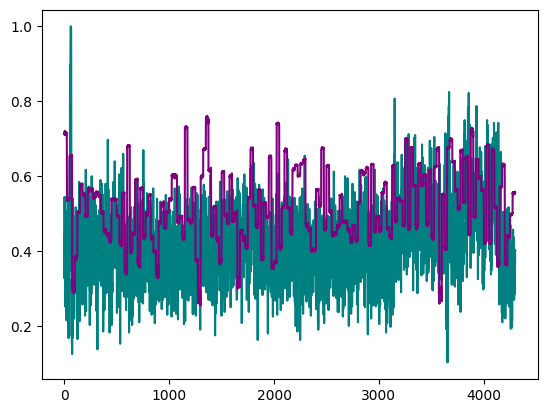

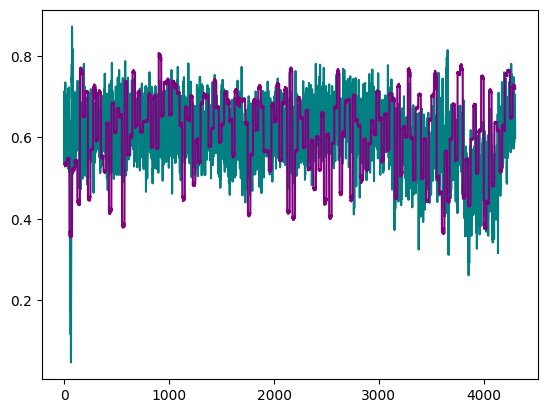

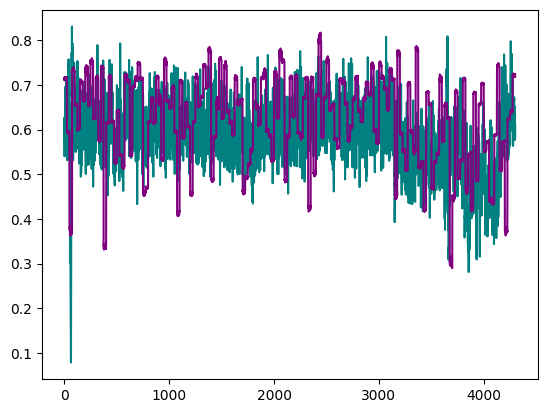

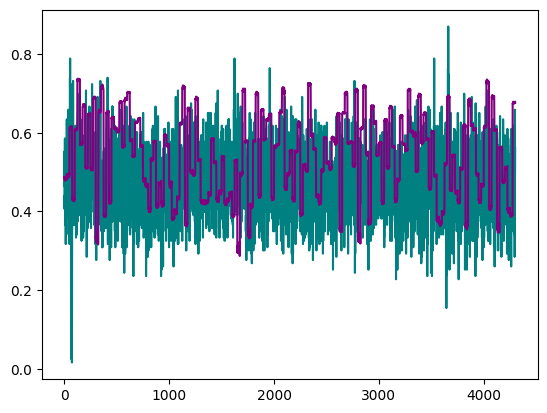

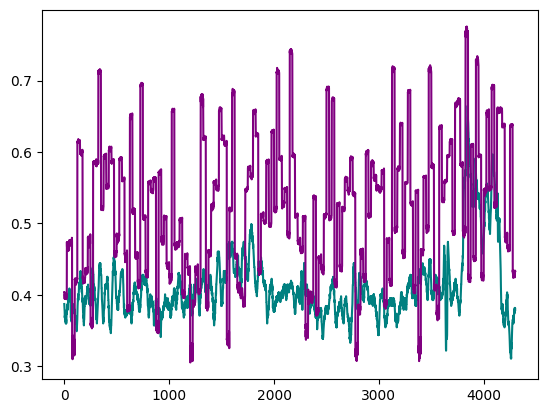

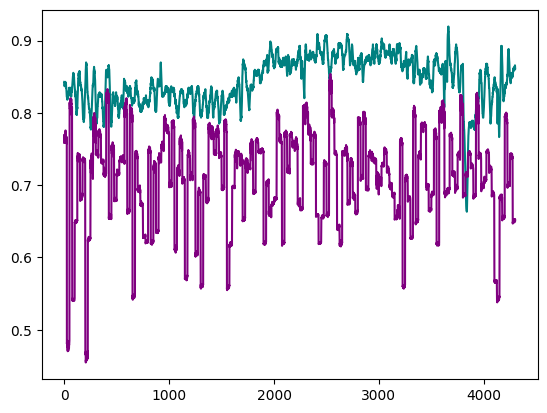

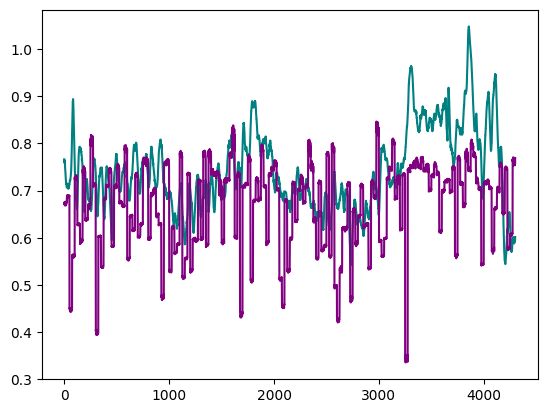

In [204]:
import matplotlib.pyplot as plt
import numpy as np

# Encoder + Decocder (current attempt)
for sensor in range(num_sensors):
    #if sensor==0:
    pred = np.array(pred)
    truth = np.array(truth)
    plt.plot(truth[:,sensor], color="teal")
    plt.plot(pred[:,sensor], color="purple")
    plt.show()

# Eval VAE (anomalies)

In [205]:
test = torch.FloatTensor(test_dfs[0][::downsample].values)
num_timesteps, num_sensors = test.shape
num_time_windows = num_timesteps//time_window_size
length = num_time_windows*num_sensors

# Linear trend in 1st sensor
transition_point = int(num_timesteps*0.5)
test[transition_point:,0] = test[transition_point:,0] + np.arange(transition_point,num_timesteps)*(1e-4)

# Outlier in 2nd sensor
outlier_start = int(num_timesteps*0.6)
outlier_stop = int(num_timesteps*0.62)
test[outlier_start:outlier_stop,1] = test[outlier_start:outlier_stop,1]*np.random.uniform(low=5, high=6, size=(outlier_stop-outlier_start))


In [206]:
test_dataset = TimewindowDataset(test, time_window_size)
batch_size = 1
test_dataloader = DataLoader(test_dataset, shuffle=False, drop_last=True, batch_size=batch_size)

In [207]:
# Iterate over all (x,y) pairs in validation dataloader
pred  = torch.empty((num_time_windows*time_window_size,num_sensors))
truth_anom = torch.empty((num_time_windows*time_window_size,num_sensors))

with torch.no_grad():
    for i, x in enumerate(test_dataloader):
        sensor_num = i//num_time_windows
        #if sensor_num==0:
        if i%100==0:
            print(f"{i}/{len(test_dataloader)}")
        sensor_num = i//num_time_windows
        time_window = i%num_time_windows
        # Make forecasts
        prediction,_ = model(x)

        pred[time_window*time_window_size:(time_window+1)*time_window_size,sensor_num] = prediction
        truth_anom[time_window*time_window_size:(time_window+1)*time_window_size,sensor_num] = x


0/5504
100/5504
200/5504
300/5504
400/5504
500/5504
600/5504
700/5504
800/5504
900/5504
1000/5504
1100/5504
1200/5504
1300/5504
1400/5504
1500/5504
1600/5504
1700/5504
1800/5504
1900/5504
2000/5504
2100/5504
2200/5504
2300/5504
2400/5504
2500/5504
2600/5504
2700/5504
2800/5504
2900/5504
3000/5504
3100/5504
3200/5504
3300/5504
3400/5504
3500/5504
3600/5504
3700/5504
3800/5504
3900/5504
4000/5504
4100/5504
4200/5504
4300/5504
4400/5504
4500/5504
4600/5504
4700/5504
4800/5504
4900/5504
5000/5504
5100/5504
5200/5504
5300/5504
5400/5504
5500/5504


# Visualize VAE (anomalies)

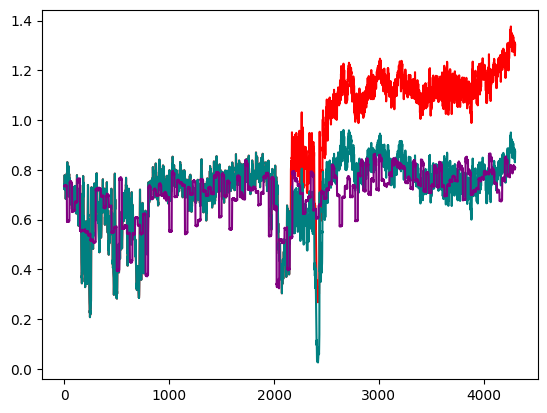

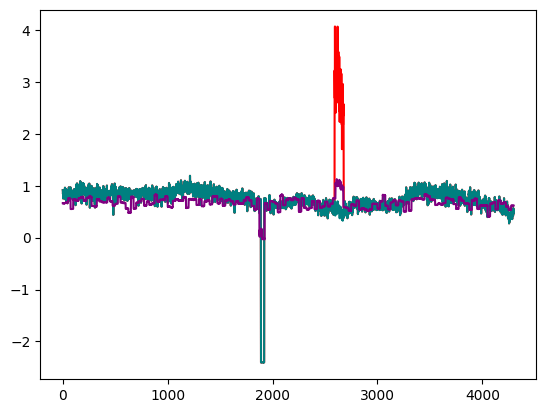

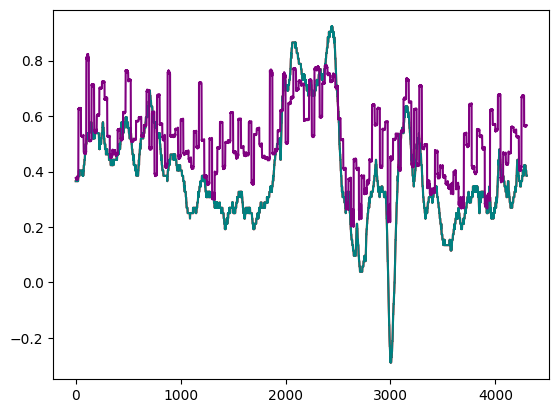

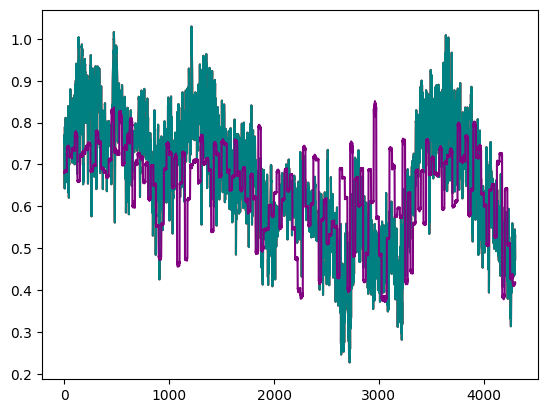

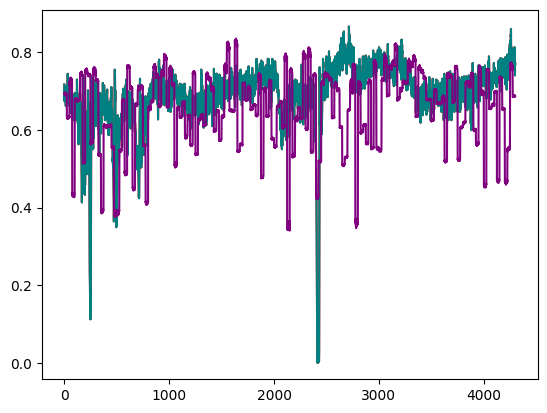

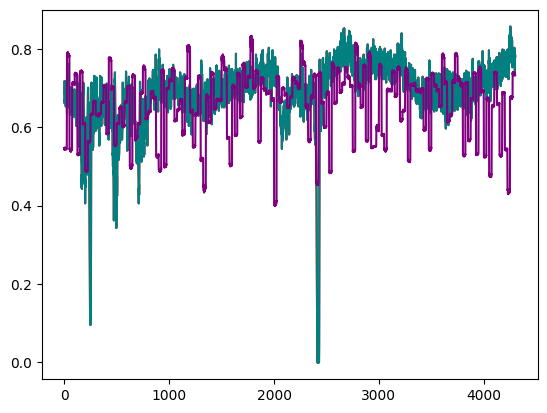

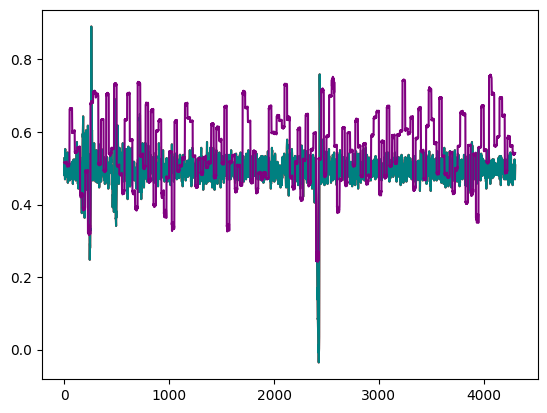

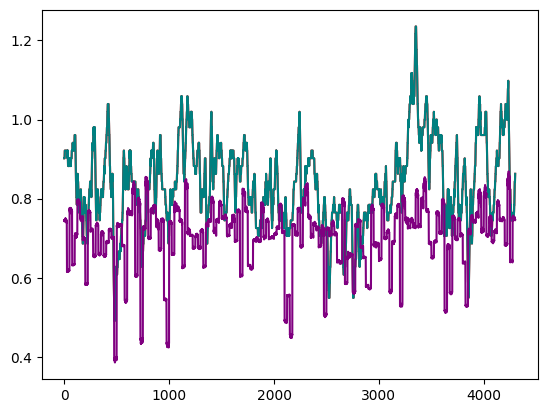

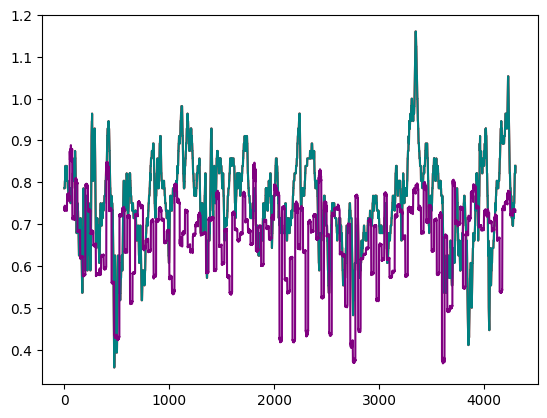

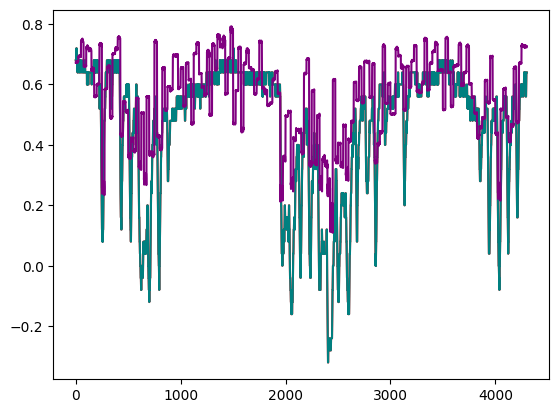

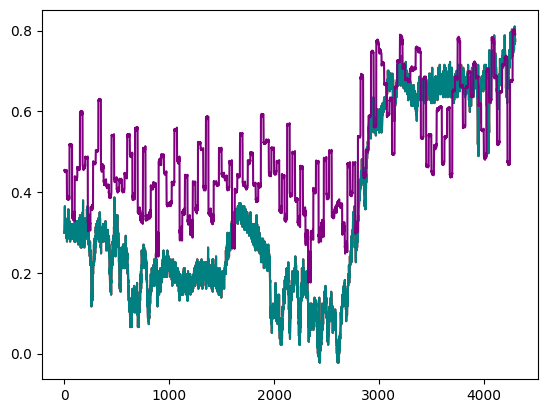

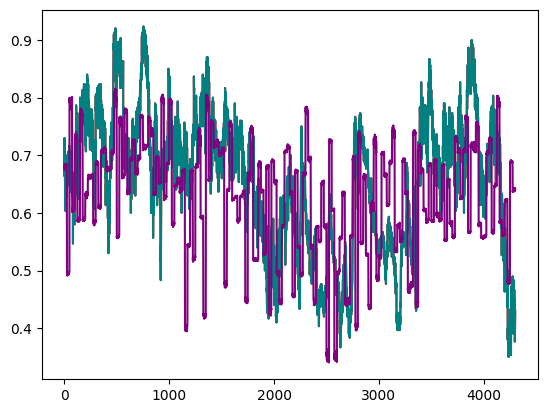

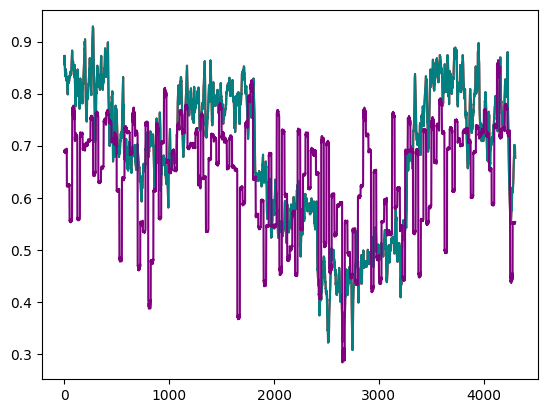

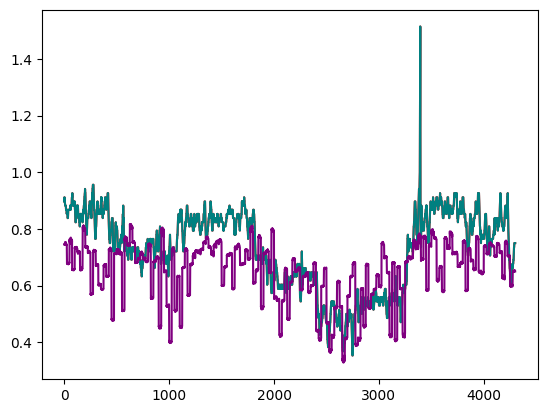

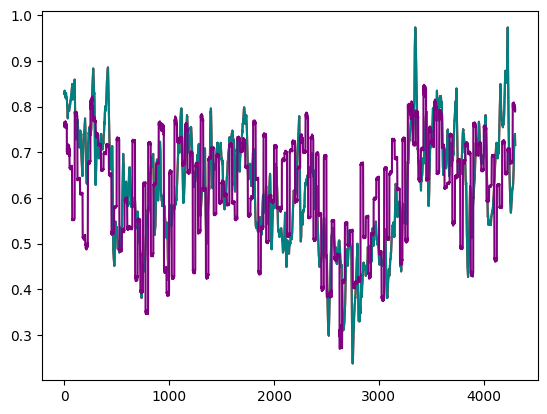

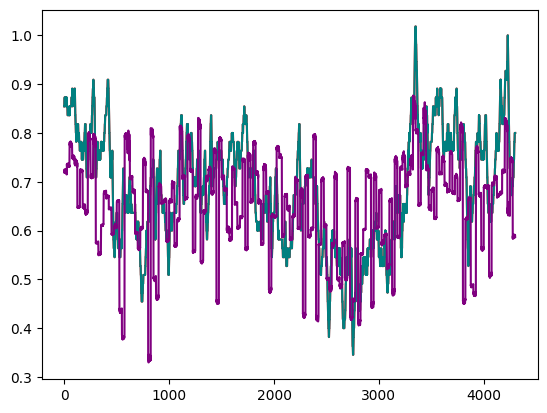

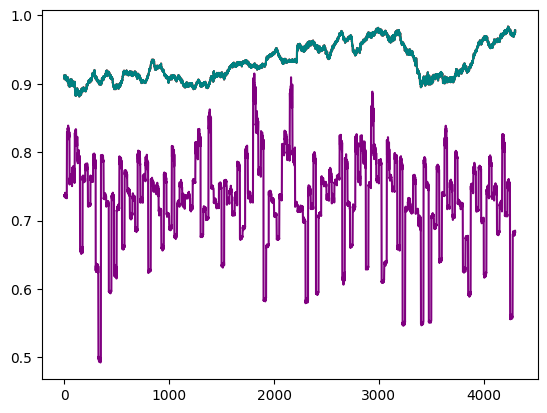

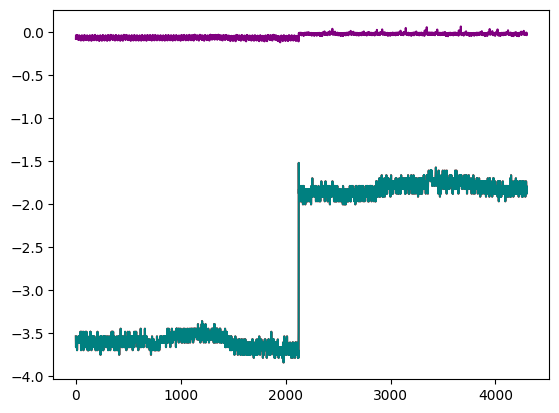

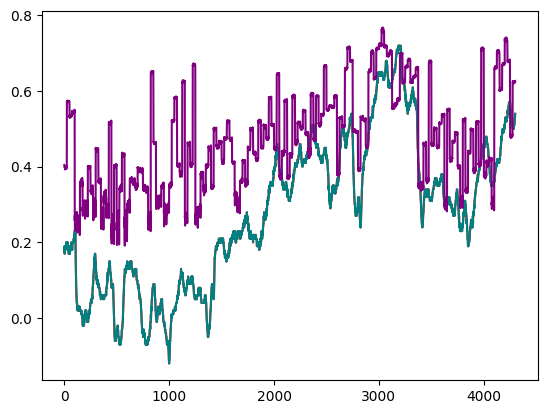

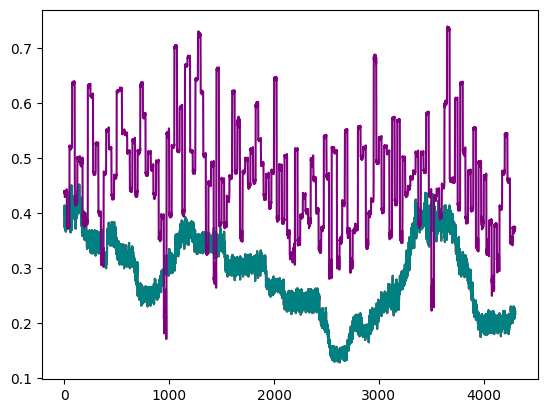

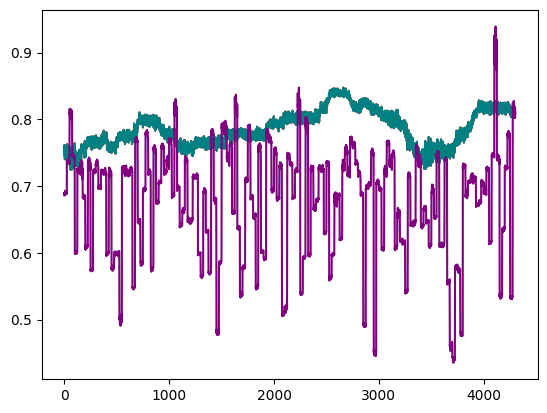

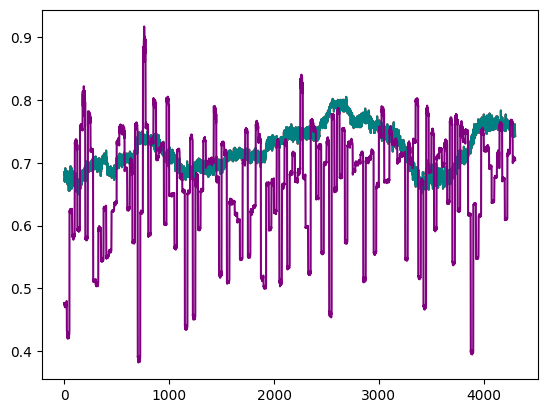

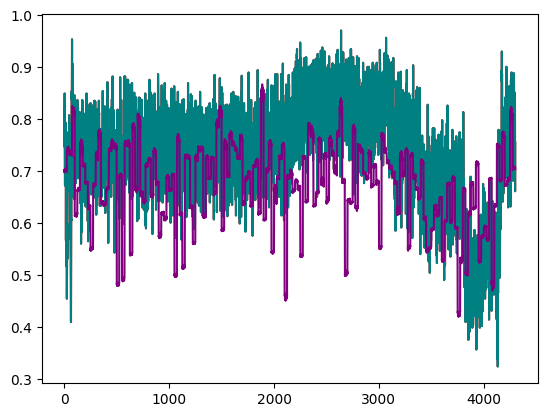

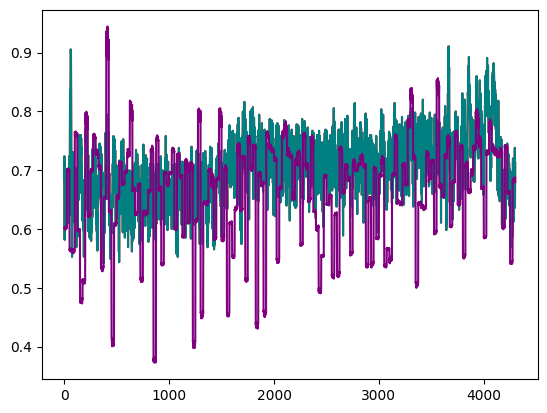

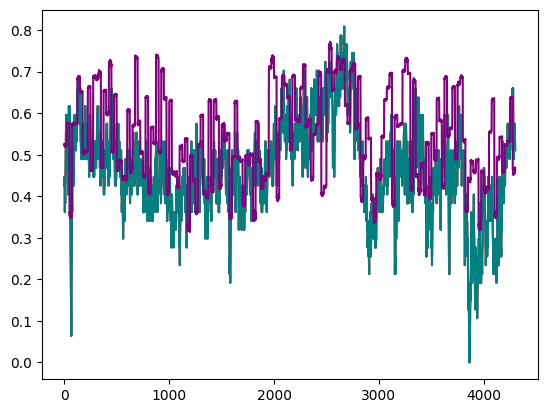

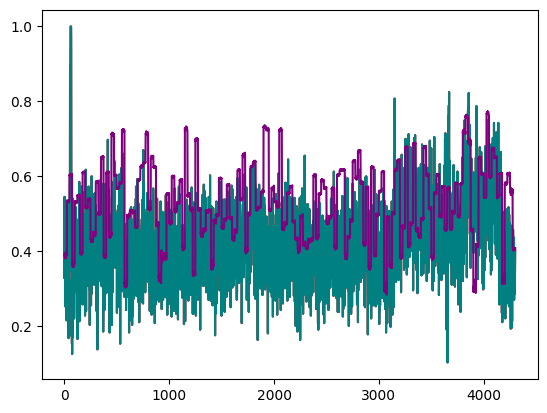

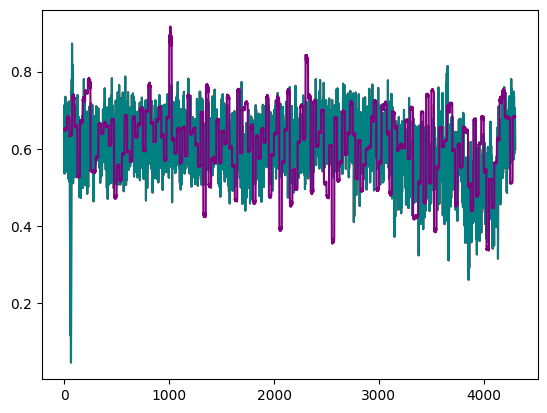

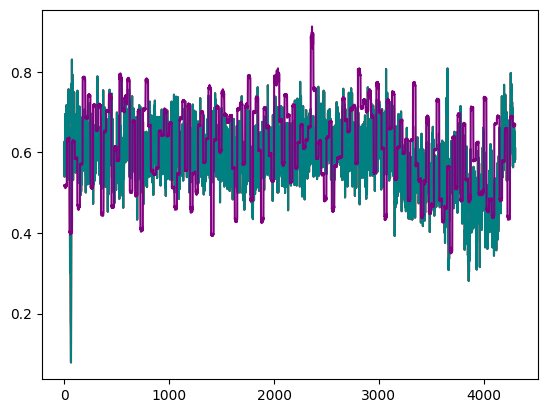

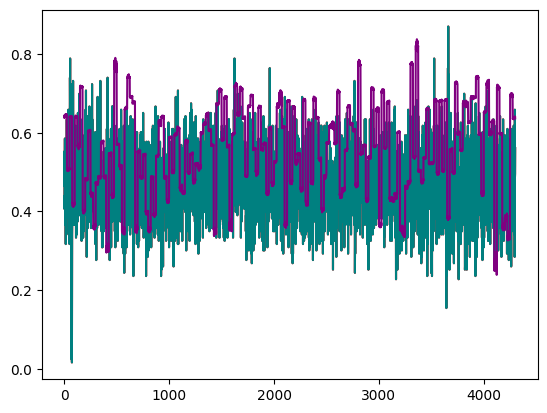

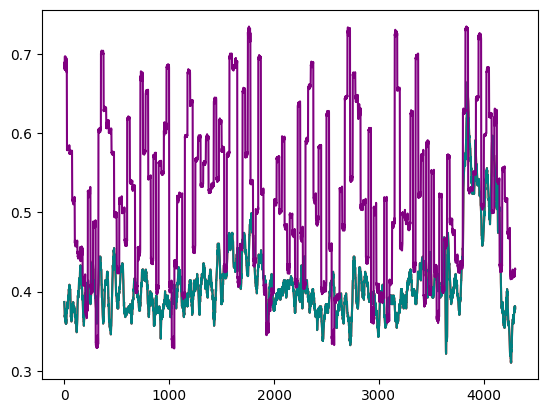

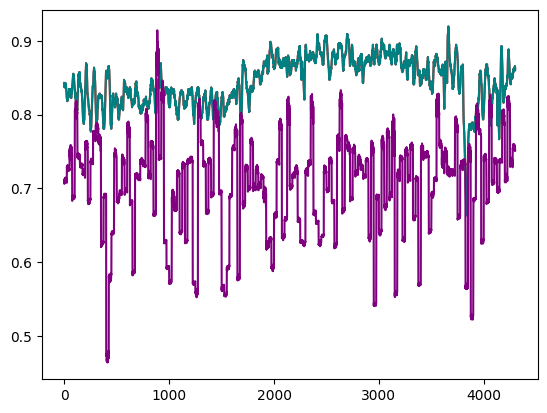

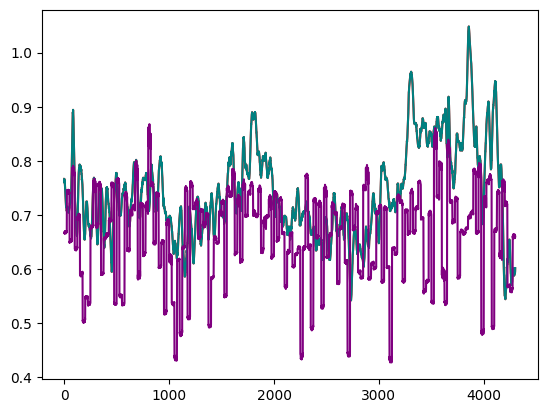

In [208]:
import matplotlib.pyplot as plt
import numpy as np

# Encoder + Decocder (current attempt)
for sensor in range(num_sensors):
    #if sensor==0:
    pred = np.array(pred)
    truth = np.array(truth)
    plt.plot(truth_anom[:,sensor], color="red")
    plt.plot(truth[:,sensor], color="teal")
    plt.plot(pred[:,sensor], color="purple")
    plt.show()